# Analysis of COVID-19 County Data from The New York Times

*Author: Mark Bauer*  
*Date: April 11, 2020*

The New York Times Github Data [Repository](https://github.com/nytimes/covid-19-data).   
The New York Time [News Article](https://www.nytimes.com/article/coronavirus-county-data-us.html).  
The New York Times COVID-19 US Map: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html.   
The New York Times COVID-19 Global Map: https://www.nytimes.com/interactive/2020/world/coronavirus-maps.html.

In [1]:
# importing libraries
import pandas as pd # the pd is by convention
import numpy as np # as is the np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
import seaborn as sns
import geopandas as gpd
import zipfile
from zipfile import ZipFile
from io import BytesIO
import os
import zipfile
from zipfile import ZipFile
from os.path import basename
import requests
import urllib
import squarify  

# to Plot matplotlib figures inline on the notebook
%matplotlib inline
sns.set(color_codes=True)

In [2]:
#Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.2.0

numpy 1.16.1
pandas 1.0.0
matplotlib 3.0.2
matplotlib.pyplot 3.0.2
seaborn 0.9.0


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

covid_19_counties_data = pd.read_csv(url)

In [4]:
covid_19_counties_data.head(10)

date       county       state     fips  cases  deaths
0  2020-01-21    Snohomish  Washington  53061.0      1       0
1  2020-01-22    Snohomish  Washington  53061.0      1       0
2  2020-01-23    Snohomish  Washington  53061.0      1       0
3  2020-01-24         Cook    Illinois  17031.0      1       0
4  2020-01-24    Snohomish  Washington  53061.0      1       0
5  2020-01-25       Orange  California   6059.0      1       0
6  2020-01-25         Cook    Illinois  17031.0      1       0
7  2020-01-25    Snohomish  Washington  53061.0      1       0
8  2020-01-26     Maricopa     Arizona   4013.0      1       0
9  2020-01-26  Los Angeles  California   6037.0      1       0

In [5]:
table = covid_19_counties_data.sort_values(by=['date', 'cases'], 
                                ascending=[False, False]).drop_duplicates(subset ="county", 
                                keep = 'first').reset_index(drop=True).head(10)

table['cases'] = table['cases'].map('{:,}'.format)
table['deaths'] = table['deaths'].map('{:,}'.format)
table.drop('fips', axis=1, inplace=True)
                 
print(table.to_markdown())

|    | date       | county        | state      | cases   | deaths   |
|---:|:-----------|:--------------|:-----------|:--------|:---------|
|  0 | 2020-04-13 | New York City | New York   | 106,764 | 7,154    |
|  1 | 2020-04-13 | Nassau        | New York   | 24,358  | 1,109    |
|  2 | 2020-04-13 | Suffolk       | New York   | 21,643  | 580      |
|  3 | 2020-04-13 | Westchester   | New York   | 19,785  | 610      |
|  4 | 2020-04-13 | Cook          | Illinois   | 15,474  | 543      |
|  5 | 2020-04-13 | Wayne         | Michigan   | 11,648  | 760      |
|  6 | 2020-04-13 | Bergen        | New Jersey | 10,092  | 482      |
|  7 | 2020-04-13 | Los Angeles   | California | 9,420   | 320      |
|  8 | 2020-04-13 | Rockland      | New York   | 7,965   | 182      |
|  9 | 2020-04-13 | Hudson        | New Jersey | 7,879   | 236      |


In [6]:
covid_19_counties_data.shape

(56541, 6)

In [7]:
print('New York Times COVID-19 data as of', covid_19_counties_data.sort_values(by='date', 
                                   ascending=False)['date'].iloc[0])

New York Times COVID-19 data as of 2020-04-13


In [8]:
current_date = covid_19_counties_data.sort_values(by='date', ascending=False)['date'].iloc[0]

In [9]:
print('The current date of this notebook is', current_date)

The current date of this notebook is 2020-04-13


In [10]:
covid_19_counties_data.date = pd.to_datetime(covid_19_counties_data.date, infer_datetime_format=True)

In [11]:
covid_19_counties_data.dtypes

date      datetime64[ns]
county            object
state             object
fips             float64
cases              int64
deaths             int64
dtype: object

In [12]:
print(covid_19_counties_data['county'])

0         Snohomish
1         Snohomish
2         Snohomish
3              Cook
4         Snohomish
            ...    
56536      Sublette
56537    Sweetwater
56538         Teton
56539         Uinta
56540      Washakie
Name: county, Length: 56541, dtype: object


In [13]:
covid_19_counties_data['county_name'] = (covid_19_counties_data['county'] + ", " + covid_19_counties_data['state'])

In [14]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
56536 2020-04-13    Sublette     Wyoming  56035.0      1       0   
56537 2020-04-13  Sweetwater     Wyoming  56037.0      9       0   
56538 2020-04-13       Teton     Wyoming  56039.0     56       0   
56539 2020-04-13       Uinta     Wyoming  56041.0      4       0   
56540 2020-04-13    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
56536      Sublette, Wyoming  
56537    Sweetwater, Wyoming  
56538         Teton, Wyoming  
56539         Uinta, Wyoming  
56540      Washakie, Wyoming  

[56541 rows x 7 columns]

In [15]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

date   county           state  fips  cases  deaths  \
418   2020-03-01  Unknown    Rhode Island   NaN      2       0   
450   2020-03-02  Unknown    Rhode Island   NaN      2       0   
485   2020-03-03  Unknown    Rhode Island   NaN      2       0   
522   2020-03-04  Unknown    Rhode Island   NaN      2       0   
569   2020-03-05  Unknown    Rhode Island   NaN      2       0   
...          ...      ...             ...   ...    ...     ...   
56224 2020-04-13  Unknown            Utah   NaN     44       7   
56240 2020-04-13  Unknown         Vermont   NaN      8       0   
56244 2020-04-13  Unknown  Virgin Islands   NaN     51       1   
56359 2020-04-13  Unknown        Virginia   NaN      2      49   
56403 2020-04-13  Unknown      Washington   NaN    329       0   

                   county_name  
418      Unknown, Rhode Island  
450      Unknown, Rhode Island  
485      Unknown, Rhode Island  
522      Unknown, Rhode Island  
569      Unknown, Rhode Island  
...                        ...  
56224            Unknown, Utah  
56240         Unknown, Vermont  
56244  Unknown, Virgin Islands  
56359        Unknown, Virginia  
56403      Unknown, Washington  

[677 rows x 7 columns]

In [16]:
print(len(covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']))

677


In [17]:
covid_19_counties_data = covid_19_counties_data.loc[covid_19_counties_data.county != 'Unknown']

In [18]:
covid_19_counties_data.loc[covid_19_counties_data.county == 'Unknown']

Empty DataFrame
Columns: [date, county, state, fips, cases, deaths, county_name]
Index: []

# Begin Analysis

In [19]:
drop_duplicates = covid_19_counties_data.sort_values(by="cases", ascending=False).drop_duplicates(
                                                    subset ="county_name", keep = 'first')
top_10 = drop_duplicates[0:10]
top10_list = list(top_10.county_name)
top_10  = covid_19_counties_data.loc[covid_19_counties_data['county_name'].isin(top10_list)]

In [20]:
top_10

date         county       state     fips   cases  deaths  \
3     2020-01-24           Cook    Illinois  17031.0       1       0   
6     2020-01-25           Cook    Illinois  17031.0       1       0   
9     2020-01-26    Los Angeles  California   6037.0       1       0   
11    2020-01-26           Cook    Illinois  17031.0       1       0   
14    2020-01-27    Los Angeles  California   6037.0       1       0   
...          ...            ...         ...      ...     ...     ...   
55441 2020-04-13         Nassau    New York  36059.0   24358    1109   
55442 2020-04-13  New York City    New York      NaN  106764    7154   
55453 2020-04-13       Rockland    New York  36087.0    7965     182   
55461 2020-04-13        Suffolk    New York  36103.0   21643     580   
55469 2020-04-13    Westchester    New York  36119.0   19785     610   

                   county_name  
3               Cook, Illinois  
6               Cook, Illinois  
9      Los Angeles, California  
11              Cook, Illinois  
14     Los Angeles, California  
...                        ...  
55441         Nassau, New York  
55442  New York City, New York  
55453       Rockland, New York  
55461        Suffolk, New York  
55469    Westchester, New York  

[473 rows x 7 columns]

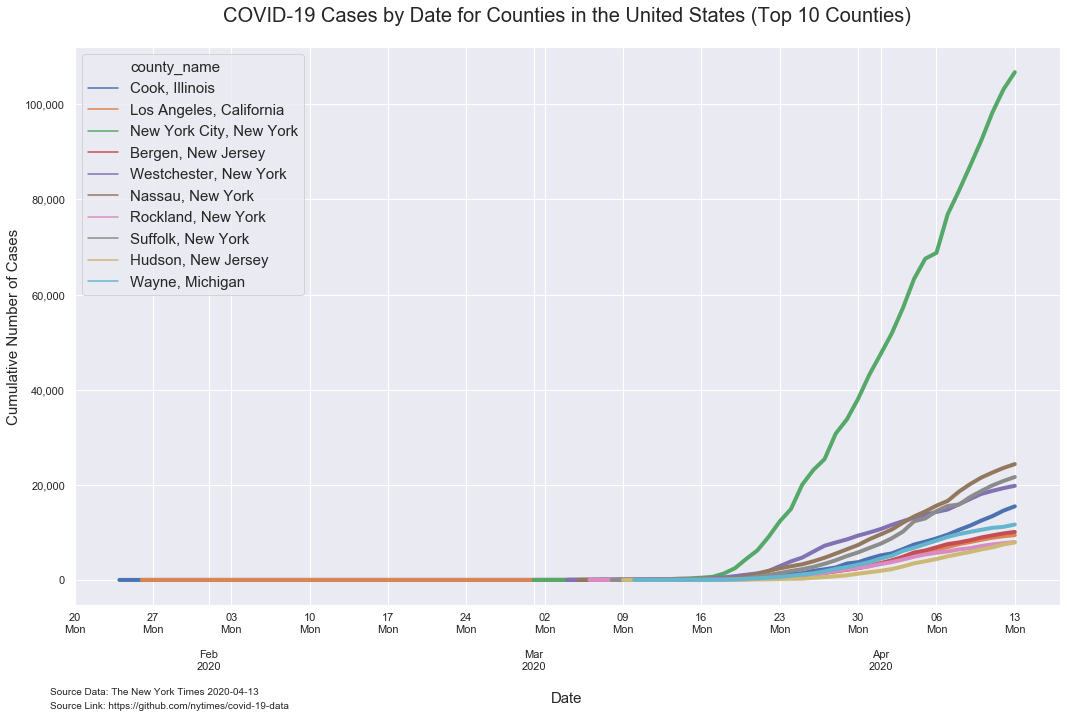

In [22]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10')

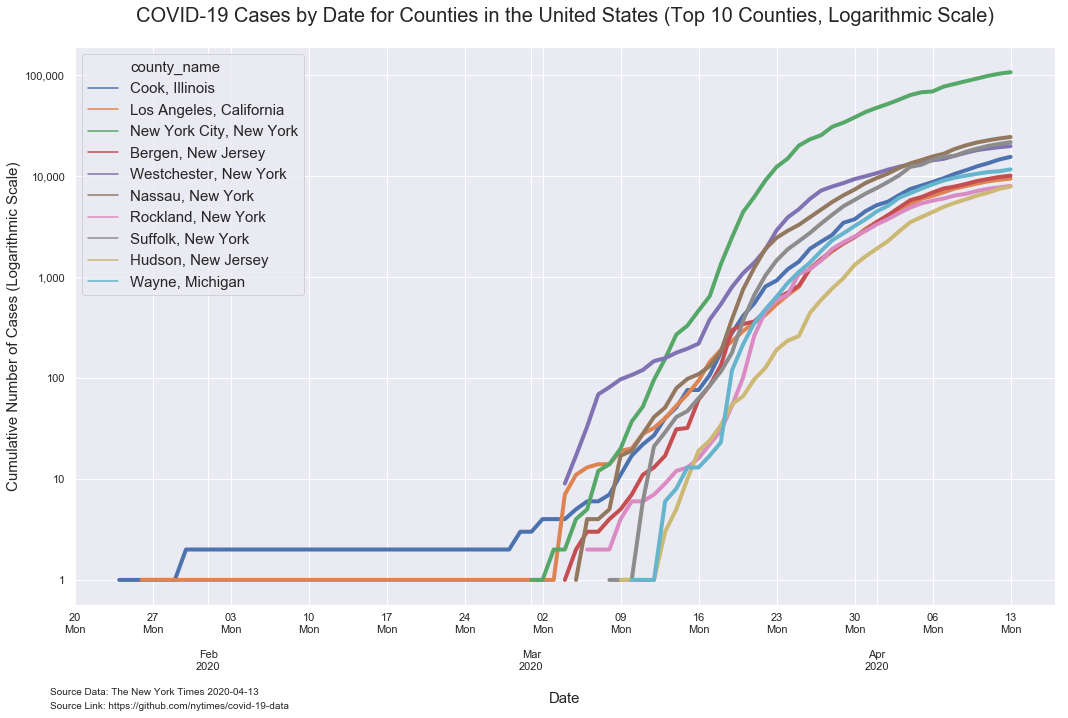

In [23]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="date", y="cases",
             hue="county_name",
             data=top_10, linewidth=4, ci=False)

ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(fontsize=15)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (Logarithmic Scale)', fontsize=15)
plt.title('COVID-19 Cases by Date for Counties in the United States (Top 10 Counties, Logarithmic Scale)', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-top10-log')

# Date to 10 Cases

In [24]:
county_ten_cases = top_10.loc[top_10.cases >= 10]

In [25]:
county_ten_cases = county_ten_cases.sort_values(by=['date', 'cases'], 
                                              ascending=[True, True]).drop_duplicates(subset ="county_name", 
                                                                                      keep = 'first').reset_index(drop=True)

In [26]:
county_ten_cases = county_ten_cases[['date', 'county_name']]
county_ten_cases.rename(columns={'date': 'date_ten_case'}, inplace=True)

In [27]:
county_ten_cases

date_ten_case              county_name
0    2020-03-05  Los Angeles, California
1    2020-03-05    Westchester, New York
2    2020-03-07  New York City, New York
3    2020-03-09           Cook, Illinois
4    2020-03-09         Nassau, New York
5    2020-03-11       Bergen, New Jersey
6    2020-03-12        Suffolk, New York
7    2020-03-14       Rockland, New York
8    2020-03-15       Hudson, New Jersey
9    2020-03-15          Wayne, Michigan

In [28]:
county_ten_cases = top_10.merge(county_ten_cases, left_on='county_name', right_on='county_name')

In [29]:
county_ten_cases

date county     state     fips  cases  deaths      county_name  \
0   2020-01-24   Cook  Illinois  17031.0      1       0   Cook, Illinois   
1   2020-01-25   Cook  Illinois  17031.0      1       0   Cook, Illinois   
2   2020-01-26   Cook  Illinois  17031.0      1       0   Cook, Illinois   
3   2020-01-27   Cook  Illinois  17031.0      1       0   Cook, Illinois   
4   2020-01-28   Cook  Illinois  17031.0      1       0   Cook, Illinois   
..         ...    ...       ...      ...    ...     ...              ...   
468 2020-04-09  Wayne  Michigan  26163.0  10093     504  Wayne, Michigan   
469 2020-04-10  Wayne  Michigan  26163.0  10539     609  Wayne, Michigan   
470 2020-04-11  Wayne  Michigan  26163.0  10951     652  Wayne, Michigan   
471 2020-04-12  Wayne  Michigan  26163.0  11164     704  Wayne, Michigan   
472 2020-04-13  Wayne  Michigan  26163.0  11648     760  Wayne, Michigan   

    date_ten_case  
0      2020-03-09  
1      2020-03-09  
2      2020-03-09  
3      2020-03-09  
4      2020-03-09  
..            ...  
468    2020-03-15  
469    2020-03-15  
470    2020-03-15  
471    2020-03-15  
472    2020-03-15  

[473 rows x 8 columns]

In [30]:
county_ten_cases = county_ten_cases.loc[county_ten_cases.cases >= 10]

In [31]:
county_ten_cases

date county     state     fips  cases  deaths      county_name  \
45  2020-03-09   Cook  Illinois  17031.0     11       0   Cook, Illinois   
46  2020-03-10   Cook  Illinois  17031.0     17       0   Cook, Illinois   
47  2020-03-11   Cook  Illinois  17031.0     22       0   Cook, Illinois   
48  2020-03-12   Cook  Illinois  17031.0     27       0   Cook, Illinois   
49  2020-03-13   Cook  Illinois  17031.0     40       0   Cook, Illinois   
..         ...    ...       ...      ...    ...     ...              ...   
468 2020-04-09  Wayne  Michigan  26163.0  10093     504  Wayne, Michigan   
469 2020-04-10  Wayne  Michigan  26163.0  10539     609  Wayne, Michigan   
470 2020-04-11  Wayne  Michigan  26163.0  10951     652  Wayne, Michigan   
471 2020-04-12  Wayne  Michigan  26163.0  11164     704  Wayne, Michigan   
472 2020-04-13  Wayne  Michigan  26163.0  11648     760  Wayne, Michigan   

    date_ten_case  
45     2020-03-09  
46     2020-03-09  
47     2020-03-09  
48     2020-03-09  
49     2020-03-09  
..            ...  
468    2020-03-15  
469    2020-03-15  
470    2020-03-15  
471    2020-03-15  
472    2020-03-15  

[348 rows x 8 columns]

In [32]:
county_ten_cases['days_since_ten_case'] = (county_ten_cases['date'] - 
                                      county_ten_cases['date_ten_case']).dt.days

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
county_ten_cases

date county     state     fips  cases  deaths      county_name  \
45  2020-03-09   Cook  Illinois  17031.0     11       0   Cook, Illinois   
46  2020-03-10   Cook  Illinois  17031.0     17       0   Cook, Illinois   
47  2020-03-11   Cook  Illinois  17031.0     22       0   Cook, Illinois   
48  2020-03-12   Cook  Illinois  17031.0     27       0   Cook, Illinois   
49  2020-03-13   Cook  Illinois  17031.0     40       0   Cook, Illinois   
..         ...    ...       ...      ...    ...     ...              ...   
468 2020-04-09  Wayne  Michigan  26163.0  10093     504  Wayne, Michigan   
469 2020-04-10  Wayne  Michigan  26163.0  10539     609  Wayne, Michigan   
470 2020-04-11  Wayne  Michigan  26163.0  10951     652  Wayne, Michigan   
471 2020-04-12  Wayne  Michigan  26163.0  11164     704  Wayne, Michigan   
472 2020-04-13  Wayne  Michigan  26163.0  11648     760  Wayne, Michigan   

    date_ten_case  days_since_ten_case  
45     2020-03-09                    0  
46     2020-03-09                    1  
47     2020-03-09                    2  
48     2020-03-09                    3  
49     2020-03-09                    4  
..            ...                  ...  
468    2020-03-15                   25  
469    2020-03-15                   26  
470    2020-03-15                   27  
471    2020-03-15                   28  
472    2020-03-15                   29  

[348 rows x 9 columns]

# Daily Number of Cases Since 10th Case

In [34]:
county_ten_cases['daily_cases'] = (county_ten_cases.cases -
                                county_ten_cases.cases.shift(1))

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
county_ten_cases[:50]

date       county       state     fips  cases  deaths  \
45  2020-03-09         Cook    Illinois  17031.0     11       0   
46  2020-03-10         Cook    Illinois  17031.0     17       0   
47  2020-03-11         Cook    Illinois  17031.0     22       0   
48  2020-03-12         Cook    Illinois  17031.0     27       0   
49  2020-03-13         Cook    Illinois  17031.0     40       0   
50  2020-03-14         Cook    Illinois  17031.0     51       0   
51  2020-03-15         Cook    Illinois  17031.0     76       0   
52  2020-03-16         Cook    Illinois  17031.0     76       0   
53  2020-03-17         Cook    Illinois  17031.0    107       1   
54  2020-03-18         Cook    Illinois  17031.0    179       1   
55  2020-03-19         Cook    Illinois  17031.0    279       2   
56  2020-03-20         Cook    Illinois  17031.0    412       3   
57  2020-03-21         Cook    Illinois  17031.0    548       4   
58  2020-03-22         Cook    Illinois  17031.0    805       6   
59  2020-03-23         Cook    Illinois  17031.0    922       9   
60  2020-03-24         Cook    Illinois  17031.0   1194      12   
61  2020-03-25         Cook    Illinois  17031.0   1418      13   
62  2020-03-26         Cook    Illinois  17031.0   1904      18   
63  2020-03-27         Cook    Illinois  17031.0   2239      20   
64  2020-03-28         Cook    Illinois  17031.0   2613      28   
65  2020-03-29         Cook    Illinois  17031.0   3445      40   
66  2020-03-30         Cook    Illinois  17031.0   3727      44   
67  2020-03-31         Cook    Illinois  17031.0   4496      61   
68  2020-04-01         Cook    Illinois  17031.0   5152      95   
69  2020-04-02         Cook    Illinois  17031.0   5575     107   
70  2020-04-03         Cook    Illinois  17031.0   6473     141   
71  2020-04-04         Cook    Illinois  17031.0   7439     167   
72  2020-04-05         Cook    Illinois  17031.0   8043     186   
73  2020-04-06         Cook    Illinois  17031.0   8728     209   
74  2020-04-07         Cook    Illinois  17031.0   9509     249   
75  2020-04-08         Cook    Illinois  17031.0  10520     312   
76  2020-04-09         Cook    Illinois  17031.0  11415     351   
77  2020-04-10         Cook    Illinois  17031.0  12472     398   
78  2020-04-11         Cook    Illinois  17031.0  13417     453   
79  2020-04-12         Cook    Illinois  17031.0  14585     485   
80  2020-04-13         Cook    Illinois  17031.0  15474     543   
120 2020-03-05  Los Angeles  California   6037.0     11       0   
121 2020-03-06  Los Angeles  California   6037.0     13       0   
122 2020-03-07  Los Angeles  California   6037.0     14       0   
123 2020-03-08  Los Angeles  California   6037.0     14       0   
124 2020-03-09  Los Angeles  California   6037.0     19       0   
125 2020-03-10  Los Angeles  California   6037.0     20       0   
126 2020-03-11  Los Angeles  California   6037.0     28       1   
127 2020-03-12  Los Angeles  California   6037.0     32       1   
128 2020-03-13  Los Angeles  California   6037.0     40       1   
129 2020-03-14  Los Angeles  California   6037.0     53       1   
130 2020-03-15  Los Angeles  California   6037.0     69       1   
131 2020-03-16  Los Angeles  California   6037.0     94       1   
132 2020-03-17  Los Angeles  California   6037.0    144       1   
133 2020-03-18  Los Angeles  California   6037.0    190       1   

                 county_name date_ten_case  days_since_ten_case  daily_cases  
45            Cook, Illinois    2020-03-09                    0          NaN  
46            Cook, Illinois    2020-03-09                    1          6.0  
47            Cook, Illinois    2020-03-09                    2          5.0  
48            Cook, Illinois    2020-03-09                    3          5.0  
49            Cook, Illinois    2020-03-09                    4         13.0  
50            Cook, Illinois    2020-03-09                    5         11.0  
51            Cook, Illinois    2020-03

In [36]:
county_ten_cases.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'county_name',
       'date_ten_case', 'days_since_ten_case', 'daily_cases'],
      dtype='object')

In [37]:
county_ten_cases = county_ten_cases[['date', 'county', 'county_name', 'cases',  
                                   'daily_cases', 'deaths', 'date_ten_case','days_since_ten_case']]

In [38]:
county_ten_cases[250:300]

date    county         county_name  cases  daily_cases  deaths  \
360 2020-04-09  Rockland  Rockland, New York   6665        252.0     117   
361 2020-04-10  Rockland  Rockland, New York   7122        457.0     135   
362 2020-04-11  Rockland  Rockland, New York   7477        355.0     153   
363 2020-04-12  Rockland  Rockland, New York   7721        244.0     166   
364 2020-04-13  Rockland  Rockland, New York   7965        244.0     182   
369 2020-03-12   Suffolk   Suffolk, New York     21      -7944.0       0   
370 2020-03-13   Suffolk   Suffolk, New York     29          8.0       0   
371 2020-03-14   Suffolk   Suffolk, New York     41         12.0       0   
372 2020-03-15   Suffolk   Suffolk, New York     47          6.0       0   
373 2020-03-16   Suffolk   Suffolk, New York     63         16.0       2   
374 2020-03-17   Suffolk   Suffolk, New York     84         21.0       3   
375 2020-03-18   Suffolk   Suffolk, New York    116         32.0       3   
376 2020-03-19   Suffolk   Suffolk, New York    178         62.0       3   
377 2020-03-20   Suffolk   Suffolk, New York    371        193.0       7   
378 2020-03-21   Suffolk   Suffolk, New York    662        291.0       9   
379 2020-03-22   Suffolk   Suffolk, New York   1034        372.0      12   
380 2020-03-23   Suffolk   Suffolk, New York   1458        424.0      13   
381 2020-03-24   Suffolk   Suffolk, New York   1880        422.0      13   
382 2020-03-25   Suffolk   Suffolk, New York   2260        380.0      20   
383 2020-03-26   Suffolk   Suffolk, New York   2735        475.0      22   
384 2020-03-27   Suffolk   Suffolk, New York   3385        650.0      22   
385 2020-03-28   Suffolk   Suffolk, New York   4138        753.0      37   
386 2020-03-29   Suffolk   Suffolk, New York   5023        885.0      40   
387 2020-03-30   Suffolk   Suffolk, New York   5791        768.0      44   
388 2020-03-31   Suffolk   Suffolk, New York   6713        922.0      53   
389 2020-04-01   Suffolk   Suffolk, New York   7605        892.0      69   
390 2020-04-02   Suffolk   Suffolk, New York   8746       1141.0      84   
391 2020-04-03   Suffolk   Suffolk, New York  10154       1408.0      96   
392 2020-04-04   Suffolk   Suffolk, New York  12328       2174.0     175   
393 2020-04-05   Suffolk   Suffolk, New York  12933        605.0     175   
394 2020-04-06   Suffolk   Suffolk, New York  14473       1540.0     237   
395 2020-04-07   Suffolk   Suffolk, New York  15561       1088.0     266   
396 2020-04-08   Suffolk   Suffolk, New York  15844        283.0     328   
397 2020-04-09   Suffolk   Suffolk, New York  17413       1569.0     369   
398 2020-04-10   Suffolk   Suffolk, New York  18692       1279.0     425   
399 2020-04-11   Suffolk   Suffolk, New York  19883       1191.0     469   
400 2020-04-12   Suffolk   Suffolk, New York  20816        933.0     529   
401 2020-04-13   Suffolk   Suffolk, New York  21643        827.0     580   
408 2020-03-15    Hudson  Hudson, New Jersey     10     -21633.0       0   
409 2020-03-16    Hudson  Hudson, New Jersey     19          9.0       0   
410 2020-03-17    Hudson  Hudson, New Jersey     24          5.0       0   
411 2020-03-18    Hudson  Hudson, New Jersey     34         10.0       0   
412 2020-03-19    Hudson  Hudson, New Jersey     55         21.0       0   
413 2020-03-20    Hudson  Hudson, New Jersey     66         11.0       0   
414 2020-03-21    Hudson  Hudson, New Jersey     97         31.0       0   
415 2020-03-22    Hudson  Hudson, New Jersey    126         29.0       0   
416 2020-03-23    Hudson  Hudson, New Jersey    190         64.0       0   
417 2020-03-24    Hudson  Hudson, New Jersey    234         44.0       3   
418 2020-03-25    Hudson  Hudson, New Jersey    260         26.0       4   
419 2020-03-26    Hudson  Hudson, New Jersey    441        181.0       4   

    date_ten_case  days_since_ten_case  
360    2020-03-14                   26  
361    2020-03-14                   27  
362    202

In [39]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases < 0] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases.isnull()] = county_ten_cases['cases'] - 10

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
county_ten_cases[:50]

date       county              county_name  cases  daily_cases  \
45  2020-03-09         Cook           Cook, Illinois     11          1.0   
46  2020-03-10         Cook           Cook, Illinois     17          6.0   
47  2020-03-11         Cook           Cook, Illinois     22          5.0   
48  2020-03-12         Cook           Cook, Illinois     27          5.0   
49  2020-03-13         Cook           Cook, Illinois     40         13.0   
50  2020-03-14         Cook           Cook, Illinois     51         11.0   
51  2020-03-15         Cook           Cook, Illinois     76         25.0   
52  2020-03-16         Cook           Cook, Illinois     76          0.0   
53  2020-03-17         Cook           Cook, Illinois    107         31.0   
54  2020-03-18         Cook           Cook, Illinois    179         72.0   
55  2020-03-19         Cook           Cook, Illinois    279        100.0   
56  2020-03-20         Cook           Cook, Illinois    412        133.0   
57  2020-03-21         Cook           Cook, Illinois    548        136.0   
58  2020-03-22         Cook           Cook, Illinois    805        257.0   
59  2020-03-23         Cook           Cook, Illinois    922        117.0   
60  2020-03-24         Cook           Cook, Illinois   1194        272.0   
61  2020-03-25         Cook           Cook, Illinois   1418        224.0   
62  2020-03-26         Cook           Cook, Illinois   1904        486.0   
63  2020-03-27         Cook           Cook, Illinois   2239        335.0   
64  2020-03-28         Cook           Cook, Illinois   2613        374.0   
65  2020-03-29         Cook           Cook, Illinois   3445        832.0   
66  2020-03-30         Cook           Cook, Illinois   3727        282.0   
67  2020-03-31         Cook           Cook, Illinois   4496        769.0   
68  2020-04-01         Cook           Cook, Illinois   5152        656.0   
69  2020-04-02         Cook           Cook, Illinois   5575        423.0   
70  2020-04-03         Cook           Cook, Illinois   6473        898.0   
71  2020-04-04         Cook           Cook, Illinois   7439        966.0   
72  2020-04-05         Cook           Cook, Illinois   8043        604.0   
73  2020-04-06         Cook           Cook, Illinois   8728        685.0   
74  2020-04-07         Cook           Cook, Illinois   9509        781.0   
75  2020-04-08         Cook           Cook, Illinois  10520       1011.0   
76  2020-04-09         Cook           Cook, Illinois  11415        895.0   
77  2020-04-10         Cook           Cook, Illinois  12472       1057.0   
78  2020-04-11         Cook           Cook, Illinois  13417        945.0   
79  2020-04-12         Cook           Cook, Illinois  14585       1168.0   
80  2020-04-13         Cook           Cook, Illinois  15474        889.0   
120 2020-03-05  Los Angeles  Los Angeles, California     11          1.0   
121 2020-03-06  Los Angeles  Los Angeles, California     13          2.0   
122 2020-03-07  Los Angeles  Los Angeles, California     14          1.0   
123 2020-03-08  Los Angeles  Los Angeles, California     14          0.0   
124 2020-03-09  Los Angeles  Los Angeles, California     19          5.0   
125 2020-03-10  Los Angeles  Los Angeles, California     20          1.0   
126 2020-03-11  Los Angeles  Los Angeles, California     28          8.0   
127 2020-03-12  Los Angeles  Los Angeles, California     32          4.0   
128 2020-03-13  Los Angeles  Los Angeles, California     40          8.0   
129 2020-03-14  Los Angeles  Los Angeles, California     53         13.0   
130 2020-03-15  Los Angeles  Los Angeles, California     69         16.0   
131 2020-03-16  Los Angeles  Los Angeles, California     94         25.0   
132 2020-03-17  Los Angeles  Los Angeles, California    144         50.0   
133 2020-03-18  Los Angeles  Los Angeles, California    190         46.0   

     deaths date_ten_case  days_since_ten_case  
45        0    2020-03-09                    0  
46        0    2020-03-09          

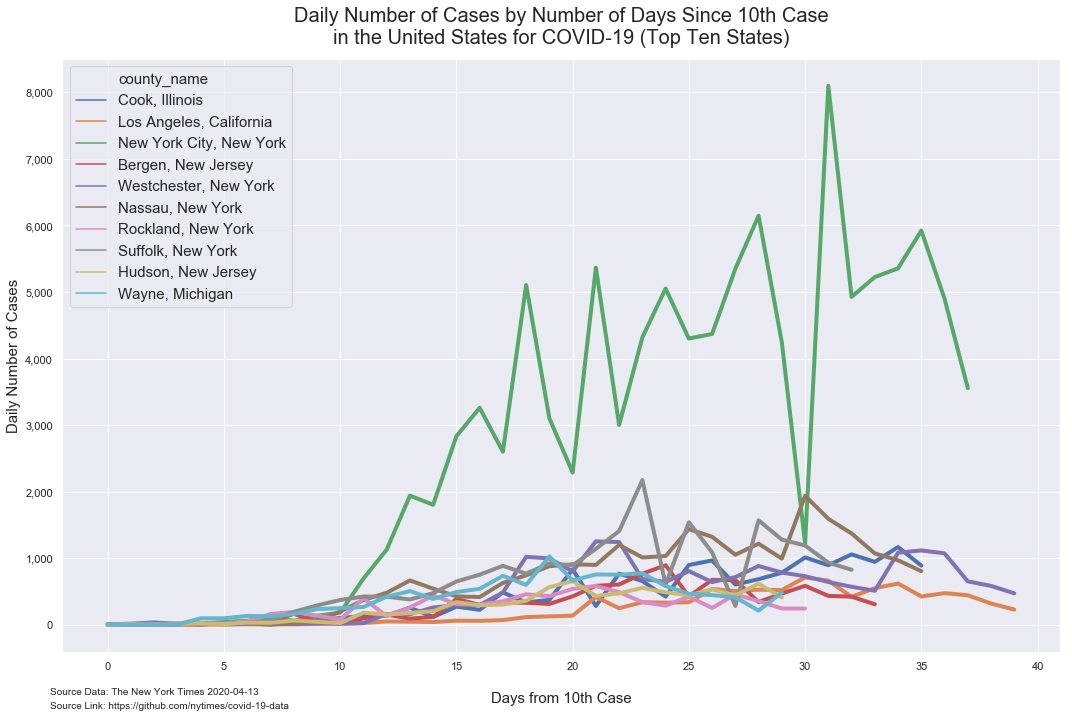

In [42]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily')

In [43]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
123    0.0
408    0.0
444    0.0
Name: daily_cases, dtype: float64

In [44]:
temp_fill_zeros = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['daily_cases'].loc[temp_fill_zeros.daily_cases == 0] = 1

temp_fill_zeros

date       county            county_name  cases  daily_cases  \
211 2020-03-11       Bergen     Bergen, New Jersey     11          1.0   
212 2020-03-12       Bergen     Bergen, New Jersey     13          2.0   
213 2020-03-13       Bergen     Bergen, New Jersey     17          4.0   
214 2020-03-14       Bergen     Bergen, New Jersey     31         14.0   
215 2020-03-15       Bergen     Bergen, New Jersey     32          1.0   
..         ...          ...                    ...    ...          ...   
281 2020-04-09  Westchester  Westchester, New York  17004       1117.0   
282 2020-04-10  Westchester  Westchester, New York  18077       1073.0   
283 2020-04-11  Westchester  Westchester, New York  18729        652.0   
284 2020-04-12  Westchester  Westchester, New York  19313        584.0   
285 2020-04-13  Westchester  Westchester, New York  19785        472.0   

     deaths date_ten_case  days_since_ten_case  
211       1    2020-03-11                    0  
212       1    2020-03-11                    1  
213       1    2020-03-11                    2  
214       1    2020-03-11                    3  
215       1    2020-03-11                    4  
..      ...           ...                  ...  
281     389    2020-03-05                   35  
282     428    2020-03-05                   36  
283     505    2020-03-05                   37  
284     562    2020-03-05                   38  
285     610    2020-03-05                   39  

[348 rows x 8 columns]

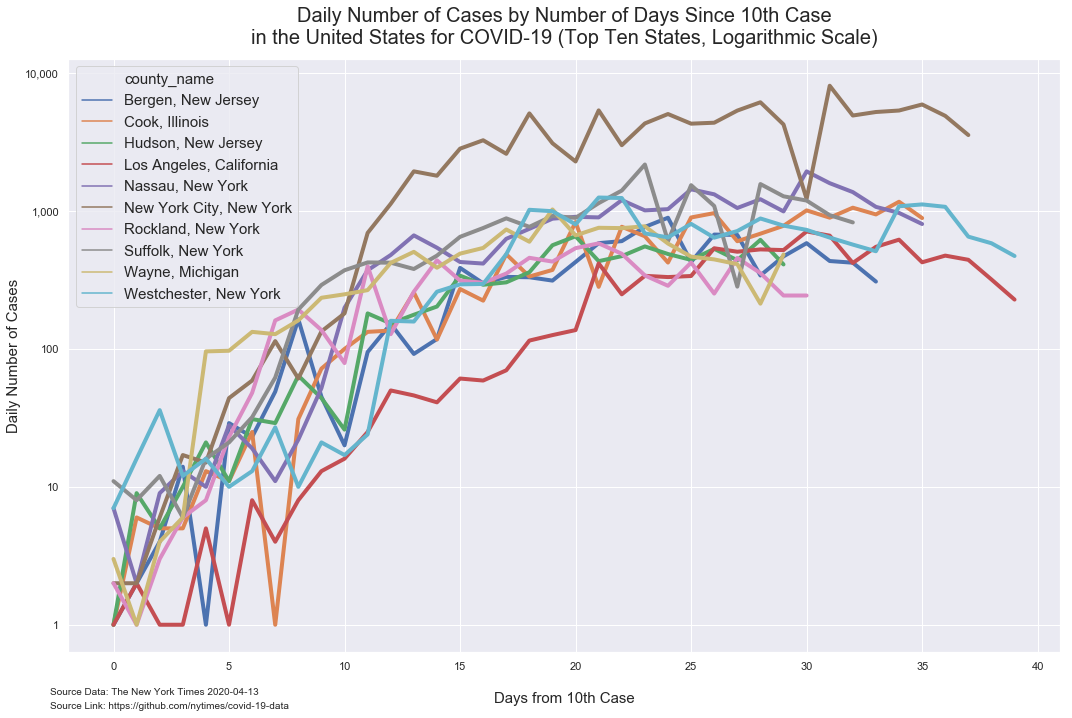

In [45]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases",
             hue="county_name",
             data=temp_fill_zeros, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-daily-log')

In [46]:
county_ten_cases['daily_cases'].loc[county_ten_cases.daily_cases == 0]

52     0.0
123    0.0
408    0.0
444    0.0
Name: daily_cases, dtype: float64

# Daily Number of Cases Since 10th Case (Weekly Average)

In [47]:
county_ten_cases_weekly = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                                    ascending=[True, True, True])

In [48]:
county_ten_cases_weekly[0:30]

date  county         county_name  cases  daily_cases  deaths  \
211 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
212 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
213 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
214 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
215 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
216 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
217 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
218 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
219 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
220 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
221 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
222 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
223 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
224 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
225 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
226 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
227 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
228 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
229 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
230 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
231 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
232 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
233 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
234 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
235 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
236 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
237 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
238 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
239 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
240 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   

    date_ten_case  days_since_ten_case  
211    2020-03-11                    0  
212    2020-03-11                    1  
213    2020-03-11                    2  
214    2020-03-11                    3  
215    2020-03-11                    4  
216    2020-03-11                    5  
217    2020-03-11                    6  
218    2020-03-11                    7  
219    2020-03-11                    8  
220    2020-03-11                    9  
221    2020-03-11                   10  
222    2020-03-11                   11  
223    2020-03-11                   12  
224    2020-03-11                   13  
225    2020-03-11                   14  
226    2020-03-11                   15  
227    2020-03-11                   16  
228    2020-03-11                   17  
229    2020-03-11                   18  
230    2020-03-11                   19  
231    2020-03-11                   20  
232    2020-03-11                   21  
233    2020-03-11                   22  
234    2020-03-11                   23  
235    2020-03-11                   24  
236    2020-03-11                   25  
237    2020-03-11                   26  
238    2020-03-11                   27  
239    2020-03-11                   28  
240    2020-03-11                   29

In [49]:
county_ten_cases_weekly = county_ten_cases_weekly.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'daily_cases': np.mean})

In [50]:
county_ten_cases_weekly

days_since_ten_case  daily_cases
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     4.400000
                      2020-03-22                   11    60.714286
                      2020-03-29                   18   244.571429
                      2020-04-05                   25   574.000000
                      2020-04-12                   32   513.857143
...                                               ...          ...
Westchester, New York 2020-03-22                   17   239.714286
                      2020-03-29                   24   949.428571
                      2020-04-05                   31   743.285714
                      2020-04-12                   38   798.714286
                      2020-04-19                   39   472.000000

[63 rows x 2 columns]

In [51]:
county_ten_cases_weekly.reset_index(inplace=True)
county_ten_cases_weekly.rename(columns={'daily_cases': 'daily_cases_week_average'}, inplace=True)

In [52]:
county_ten_cases_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
58  Westchester, New York 2020-03-22                   17   
59  Westchester, New York 2020-03-29                   24   
60  Westchester, New York 2020-04-05                   31   
61  Westchester, New York 2020-04-12                   38   
62  Westchester, New York 2020-04-19                   39   

    daily_cases_week_average  
0                   4.400000  
1                  60.714286  
2                 244.571429  
3                 574.000000  
4                 513.857143  
..                       ...  
58                239.714286  
59                949.428571  
60                743.285714  
61                798.714286  
62                472.000000  

[63 rows x 4 columns]

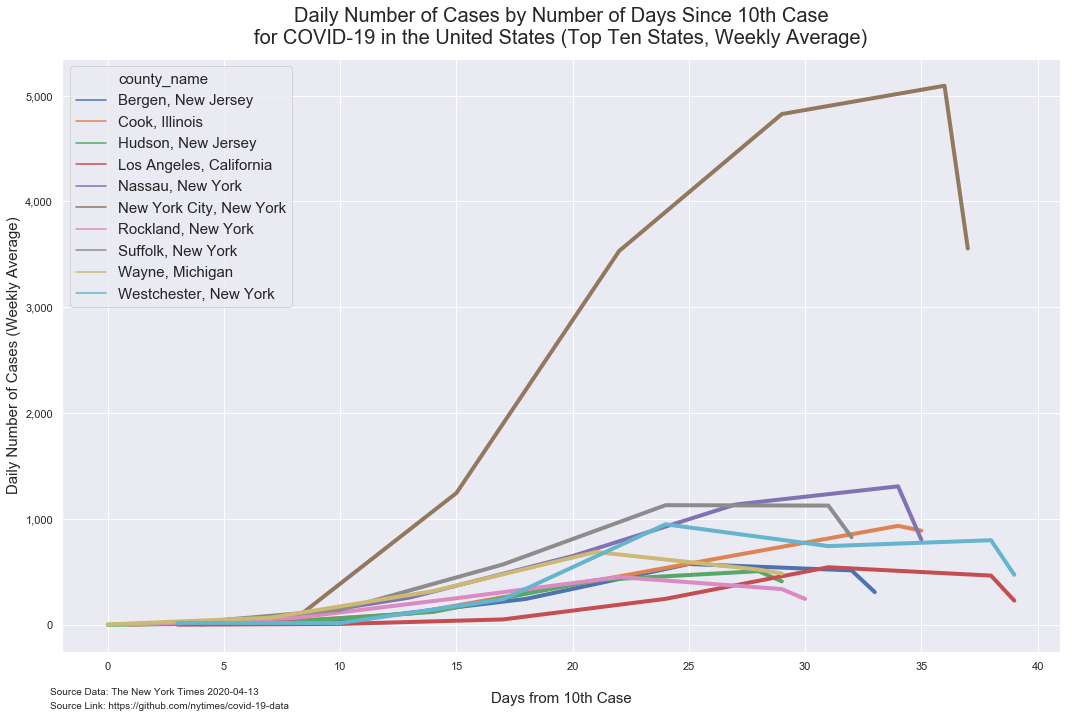

In [53]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=county_ten_cases_weekly, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly')

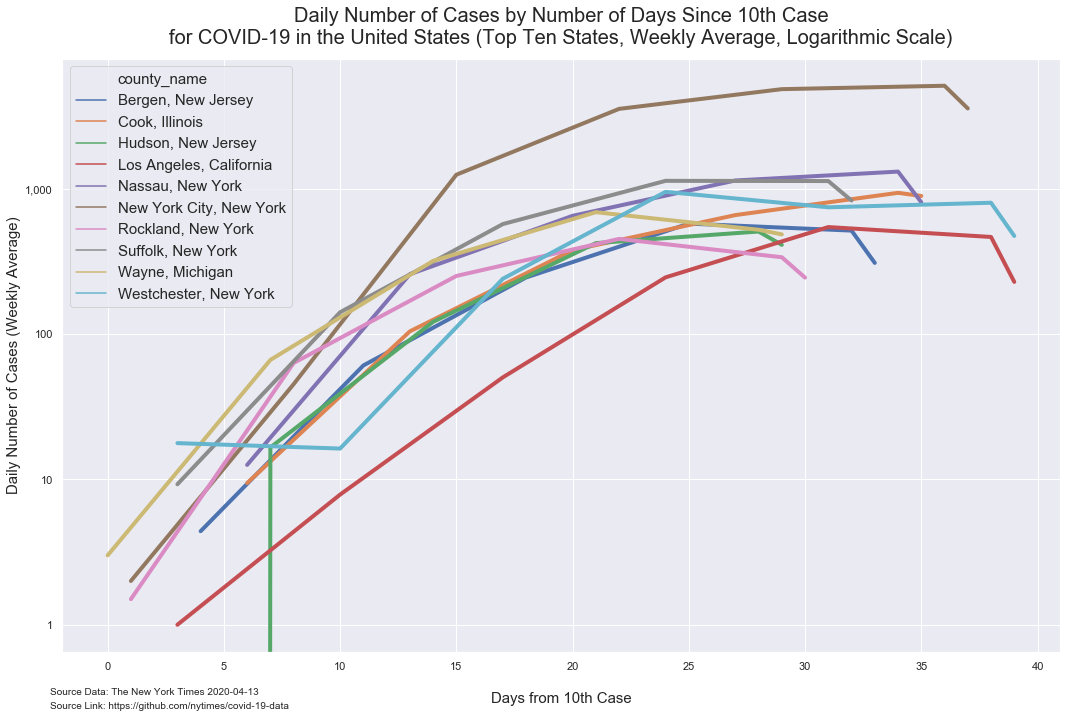

In [54]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="daily_cases_week_average",
             hue="county_name",
             data=county_ten_cases_weekly, linewidth=4)

ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Daily Number of Cases by Number of Days Since 10th Case\nfor COVID-19 in the United States (Top Ten States, Weekly Average, Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-by-county-top-10-weekly-log')

# Calculating Growth Rate = Cases Today / Cases the Previous Day

In [55]:
growth_rate = county_ten_cases.sort_values(by=['county_name', 'date', 'cases'], 
                                                ascending=[True, True, True])

In [56]:
growth_rate.head()

date  county         county_name  cases  daily_cases  deaths  \
211 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
212 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
213 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
214 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
215 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   

    date_ten_case  days_since_ten_case  
211    2020-03-11                    0  
212    2020-03-11                    1  
213    2020-03-11                    2  
214    2020-03-11                    3  
215    2020-03-11                    4

In [57]:
growth_rate['growth_rate'] = (growth_rate['daily_cases'] / growth_rate['daily_cases'].shift(1))

In [58]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
211 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
212 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
213 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
214 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
215 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
216 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
217 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
218 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
219 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
220 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
221 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
222 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
223 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
224 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
225 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
226 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
227 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
228 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
229 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
230 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
231 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
232 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
233 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
234 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
235 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
236 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
237 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
238 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
239 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
240 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
241 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
242 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
243 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
244 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   
57  2020-03-21    Cook      Cook, Illinois    548        136.0       4   
58  2020-03-22    Cook      Cook, Illinois    805        257.0       6   
59  2020-03-23    Cook      Cook, Illinois    922        117.0       9   
60  2020-03-24    Cook      Cook, Illinois   1194        272.0      12   

    date_ten_case  days_since_ten_case  growth_rate  
211    2020-03-11                    0          NaN  
212    2020-03-11                    1     2.000000  
213    2020-03-11                    2     2.000000  
214    2020-03-11  

In [59]:
growth_rate = growth_rate.loc[growth_rate.days_since_ten_case != 0]

In [60]:
inf = [np.inf, -np.inf]
growth_rate['growth_rate'] = growth_rate['growth_rate'].replace(inf, np.nan)

In [61]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
212 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
213 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
214 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
215 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
216 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
217 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
218 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
219 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
220 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
221 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
222 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
223 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
224 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
225 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
226 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
227 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
228 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
229 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
230 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
231 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
232 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
233 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
234 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
235 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
236 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
237 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
238 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
239 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
240 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
241 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
242 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
243 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
244 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   
57  2020-03-21    Cook      Cook, Illinois    548        136.0       4   
58  2020-03-22    Cook      Cook, Illinois    805        257.0       6   
59  2020-03-23    Cook      Cook, Illinois    922        117.0       9   
60  2020-03-24    Cook      Cook, Illinois   1194        272.0      12   
61  2020-03-25    Cook      Cook, Illinois   1418        224.0      13   
62  2020-03-26    Cook      Cook, Illinois   1904        486.0      18   

    date_ten_case  days_since_ten_case  growth_rate  
212    2020-03-11                    1     2.000000  
213    2020-03-11                    2     2.000000  
214    2020-03-11                    3     3.500000  
215    2020-03-11  

In [62]:
growth_rate['growth_rate'] = growth_rate['growth_rate'].fillna(method='ffill')

In [63]:
growth_rate.isna().sum()

date                   0
county                 0
county_name            0
cases                  0
daily_cases            0
deaths                 0
date_ten_case          0
days_since_ten_case    0
growth_rate            0
dtype: int64

In [64]:
growth_rate[:50]

date  county         county_name  cases  daily_cases  deaths  \
212 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
213 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
214 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
215 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
216 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
217 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
218 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
219 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
220 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
221 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
222 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
223 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
224 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
225 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
226 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
227 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
228 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
229 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
230 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
231 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
232 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
233 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
234 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
235 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
236 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
237 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
238 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
239 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
240 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
241 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
242 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
243 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
244 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   
57  2020-03-21    Cook      Cook, Illinois    548        136.0       4   
58  2020-03-22    Cook      Cook, Illinois    805        257.0       6   
59  2020-03-23    Cook      Cook, Illinois    922        117.0       9   
60  2020-03-24    Cook      Cook, Illinois   1194        272.0      12   
61  2020-03-25    Cook      Cook, Illinois   1418        224.0      13   
62  2020-03-26    Cook      Cook, Illinois   1904        486.0      18   

    date_ten_case  days_since_ten_case  growth_rate  
212    2020-03-11                    1     2.000000  
213    2020-03-11                    2     2.000000  
214    2020-03-11                    3     3.500000  
215    2020-03-11  

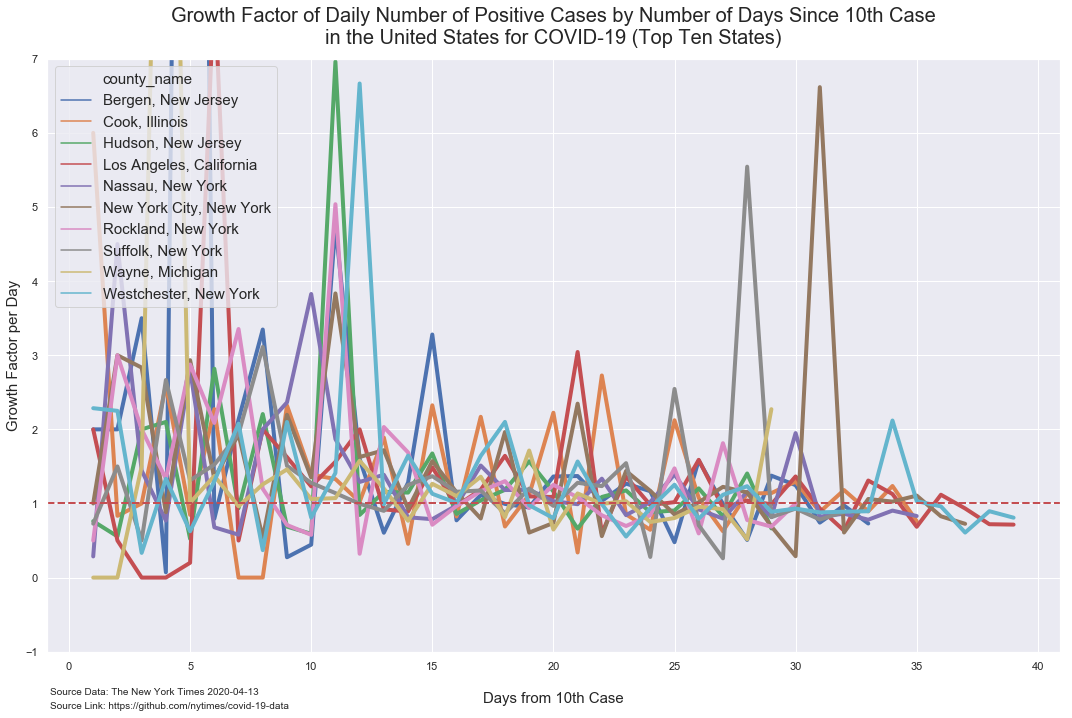

In [65]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate",
             hue="county_name", data=growth_rate , linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(-1, 7)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day', fontsize=15)
plt.title('Growth Factor of Daily Number of Positive Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-daily')

# Weekly Growth Rate

In [66]:
growth_rate_weekly = growth_rate.set_index('date').groupby('county_name').resample('W').agg({'days_since_ten_case': 
                                                                    np.max, 'growth_rate': np.mean})

In [67]:
growth_rate_weekly

days_since_ten_case  growth_rate
county_name           date                                        
Bergen, New Jersey    2020-03-15                    4     1.892857
                      2020-03-22                   11     5.819902
                      2020-03-29                   18     1.378264
                      2020-04-05                   25     1.089289
                      2020-04-12                   32     1.060000
...                                               ...          ...
Westchester, New York 2020-03-22                   17     2.070138
                      2020-03-29                   24     1.132506
                      2020-04-05                   31     1.013730
                      2020-04-12                   38     1.057008
                      2020-04-19                   39     0.808219

[61 rows x 2 columns]

In [68]:
growth_rate_weekly.reset_index(inplace=True)
growth_rate_weekly.rename(columns={'growth_rate': 'growth_rate_weekly_average'}, inplace=True)

In [69]:
growth_rate_weekly

county_name       date  days_since_ten_case  \
0      Bergen, New Jersey 2020-03-15                    4   
1      Bergen, New Jersey 2020-03-22                   11   
2      Bergen, New Jersey 2020-03-29                   18   
3      Bergen, New Jersey 2020-04-05                   25   
4      Bergen, New Jersey 2020-04-12                   32   
..                    ...        ...                  ...   
56  Westchester, New York 2020-03-22                   17   
57  Westchester, New York 2020-03-29                   24   
58  Westchester, New York 2020-04-05                   31   
59  Westchester, New York 2020-04-12                   38   
60  Westchester, New York 2020-04-19                   39   

    growth_rate_weekly_average  
0                     1.892857  
1                     5.819902  
2                     1.378264  
3                     1.089289  
4                     1.060000  
..                         ...  
56                    2.070138  
57                    1.132506  
58                    1.013730  
59                    1.057008  
60                    0.808219  

[61 rows x 4 columns]

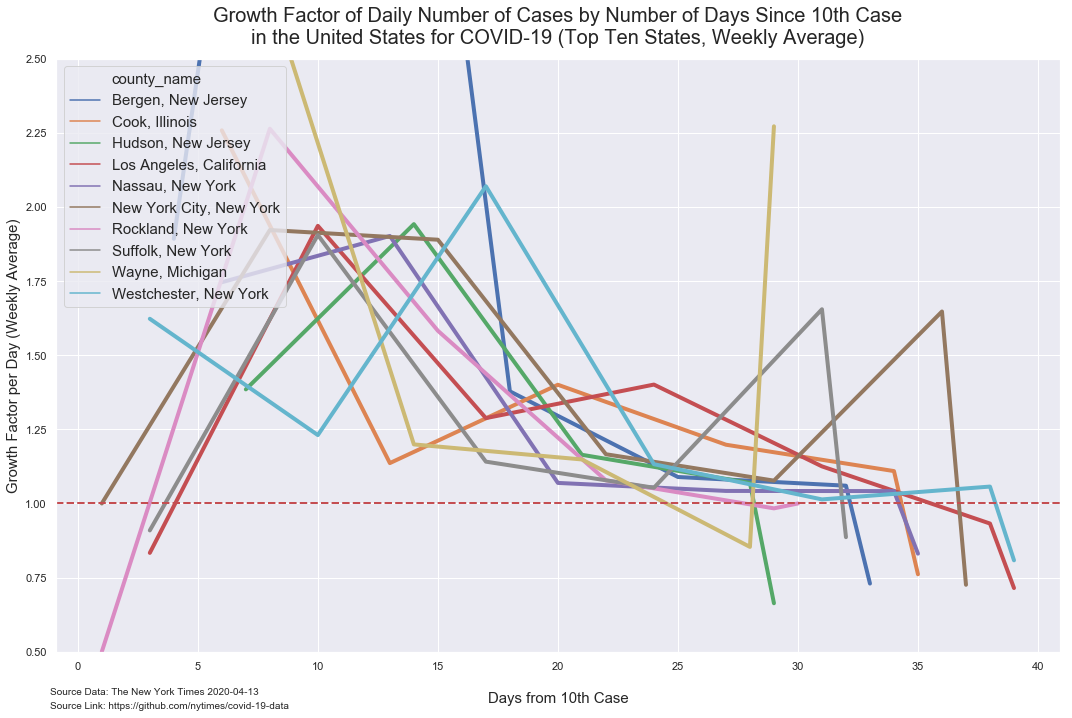

In [70]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="growth_rate_weekly_average",
             hue="county_name", data=growth_rate_weekly, linewidth=4)

ax1.axhline(1, color='r', lw=2, linestyle='dashed')

ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')
plt.ylim(0.5, 2.5)

ax1.legend(loc='upper left', fontsize=15)
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Growth Factor per Day (Weekly Average)', fontsize=15)
plt.title('Growth Factor of Daily Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top Ten States, Weekly Average)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/growth-factor-top-10-weekly')

# Cumulative Number of Cases

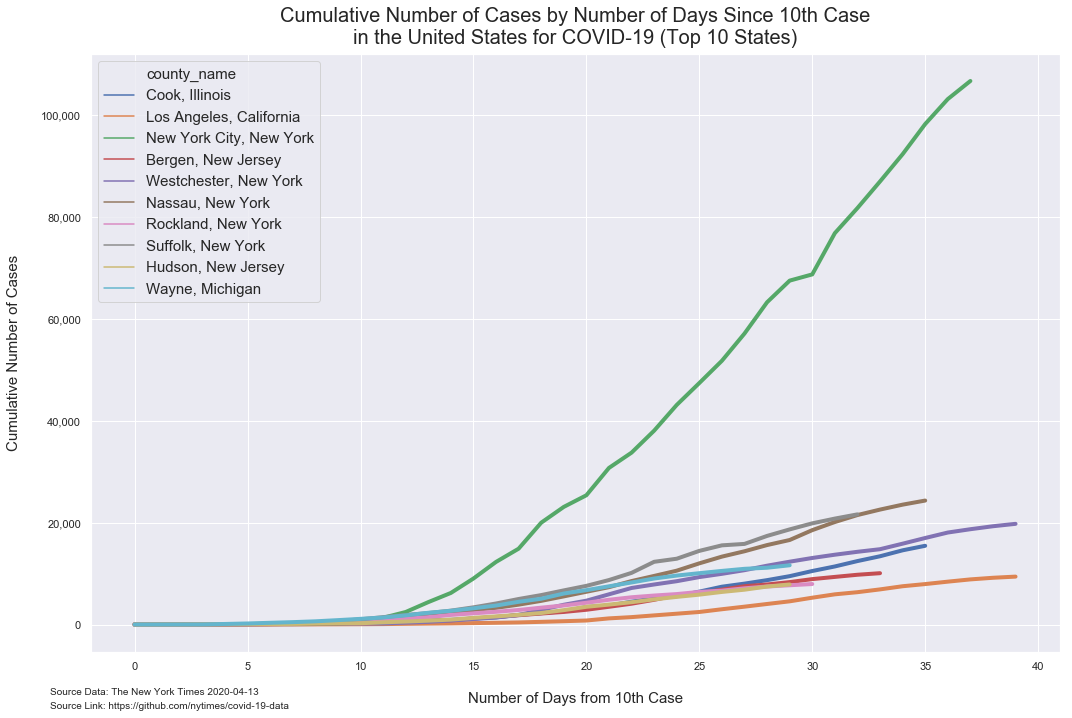

In [71]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case')

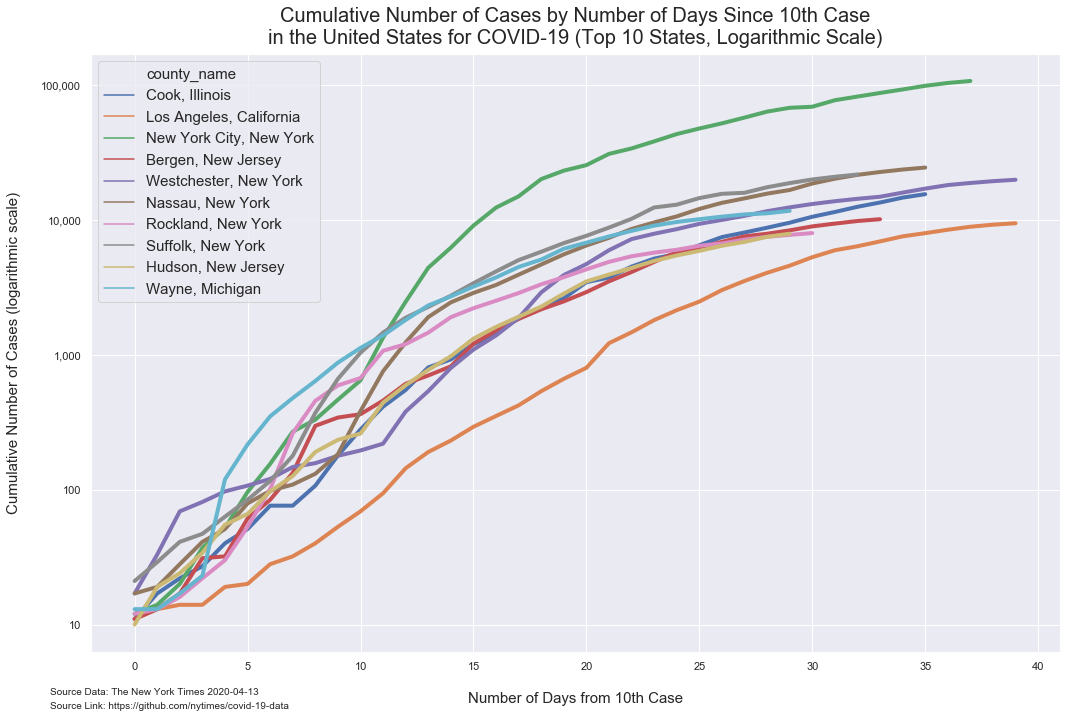

In [72]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_since_ten_case", y="cases",
             hue="county_name",
             data=county_ten_cases, linewidth=4)
    
ax1.set_yscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.grid(True)
ax1.grid(axis='x', which='minor')
ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Number of Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases (logarithmic scale)', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nin the United States for COVID-19 (Top 10 States, Logarithmic Scale)', 
          pad = 10, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-timeseries-tenth-case-log')

# Cumulative Cases for All States

In [73]:
ten_cases_all_states = covid_19_counties_data.loc[covid_19_counties_data['cases'] >= 10]

In [74]:
ten_cases_all_states = ten_cases_all_states.sort_values(by=['date', 'cases'], 
                                ascending=[True, True], ).drop_duplicates(subset ="county_name", keep = 'first').reset_index(drop=True)

In [75]:
ten_cases_all_states = ten_cases_all_states[['county_name', 'date']]
ten_cases_all_states.rename(columns={'date': 'ten_cases_date'}, inplace=True)

In [76]:
ten_cases_all_states

county_name ten_cases_date
0           Douglas, Nebraska     2020-02-17
1                Bexar, Texas     2020-02-24
2          Solano, California     2020-02-26
3            King, Washington     2020-03-01
4     Santa Clara, California     2020-03-03
...                       ...            ...
1485         Wakulla, Florida     2020-04-13
1486     Dorchester, Maryland     2020-04-13
1487    Wyoming, Pennsylvania     2020-04-13
1488  Prince Edward, Virginia     2020-04-13
1489           Wise, Virginia     2020-04-13

[1490 rows x 2 columns]

In [77]:
ten_cases_all_states = covid_19_counties_data.merge(ten_cases_all_states, left_on='county_name', right_on='county_name')

In [78]:
ten_cases_all_states = ten_cases_all_states.loc[ten_cases_all_states['cases'] >= 10]

In [79]:
ten_cases_all_states

date                 county          state     fips  cases  \
44    2020-03-05              Snohomish     Washington  53061.0     17   
45    2020-03-06              Snohomish     Washington  53061.0     18   
46    2020-03-07              Snohomish     Washington  53061.0     26   
47    2020-03-08              Snohomish     Washington  53061.0     36   
48    2020-03-09              Snohomish     Washington  53061.0     45   
...          ...                    ...            ...      ...    ...   
38402 2020-04-10                  Wayne  West Virginia  54099.0     16   
38403 2020-04-11                  Wayne  West Virginia  54099.0     17   
38404 2020-04-12                  Wayne  West Virginia  54099.0     17   
38405 2020-04-13                  Wayne  West Virginia  54099.0     19   
38409 2020-04-13  Colonial Heights city       Virginia  51570.0     10   

       deaths                      county_name ten_cases_date  
44          0            Snohomish, Washington     2020-03-05  
45          0            Snohomish, Washington     2020-03-05  
46          0            Snohomish, Washington     2020-03-05  
47          0            Snohomish, Washington     2020-03-05  
48          0            Snohomish, Washington     2020-03-05  
...       ...                              ...            ...  
38402       0             Wayne, West Virginia     2020-04-10  
38403       0             Wayne, West Virginia     2020-04-10  
38404       0             Wayne, West Virginia     2020-04-10  
38405       0             Wayne, West Virginia     2020-04-10  
38409       0  Colonial Heights city, Virginia     2020-04-13  

[22175 rows x 8 columns]

In [80]:
ten_cases_all_states['days_from_10_cases'] = (ten_cases_all_states['date'] - 
                                              ten_cases_all_states['ten_cases_date']).dt.days

In [81]:
ten_cases_all_states

date                 county          state     fips  cases  \
44    2020-03-05              Snohomish     Washington  53061.0     17   
45    2020-03-06              Snohomish     Washington  53061.0     18   
46    2020-03-07              Snohomish     Washington  53061.0     26   
47    2020-03-08              Snohomish     Washington  53061.0     36   
48    2020-03-09              Snohomish     Washington  53061.0     45   
...          ...                    ...            ...      ...    ...   
38402 2020-04-10                  Wayne  West Virginia  54099.0     16   
38403 2020-04-11                  Wayne  West Virginia  54099.0     17   
38404 2020-04-12                  Wayne  West Virginia  54099.0     17   
38405 2020-04-13                  Wayne  West Virginia  54099.0     19   
38409 2020-04-13  Colonial Heights city       Virginia  51570.0     10   

       deaths                      county_name ten_cases_date  \
44          0            Snohomish, Washington     2020-03-05   
45          0            Snohomish, Washington     2020-03-05   
46          0            Snohomish, Washington     2020-03-05   
47          0            Snohomish, Washington     2020-03-05   
48          0            Snohomish, Washington     2020-03-05   
...       ...                              ...            ...   
38402       0             Wayne, West Virginia     2020-04-10   
38403       0             Wayne, West Virginia     2020-04-10   
38404       0             Wayne, West Virginia     2020-04-10   
38405       0             Wayne, West Virginia     2020-04-10   
38409       0  Colonial Heights city, Virginia     2020-04-13   

       days_from_10_cases  
44                      0  
45                      1  
46                      2  
47                      3  
48                      4  
...                   ...  
38402                   0  
38403                   1  
38404                   2  
38405                   3  
38409                   0  

[22175 rows x 9 columns]

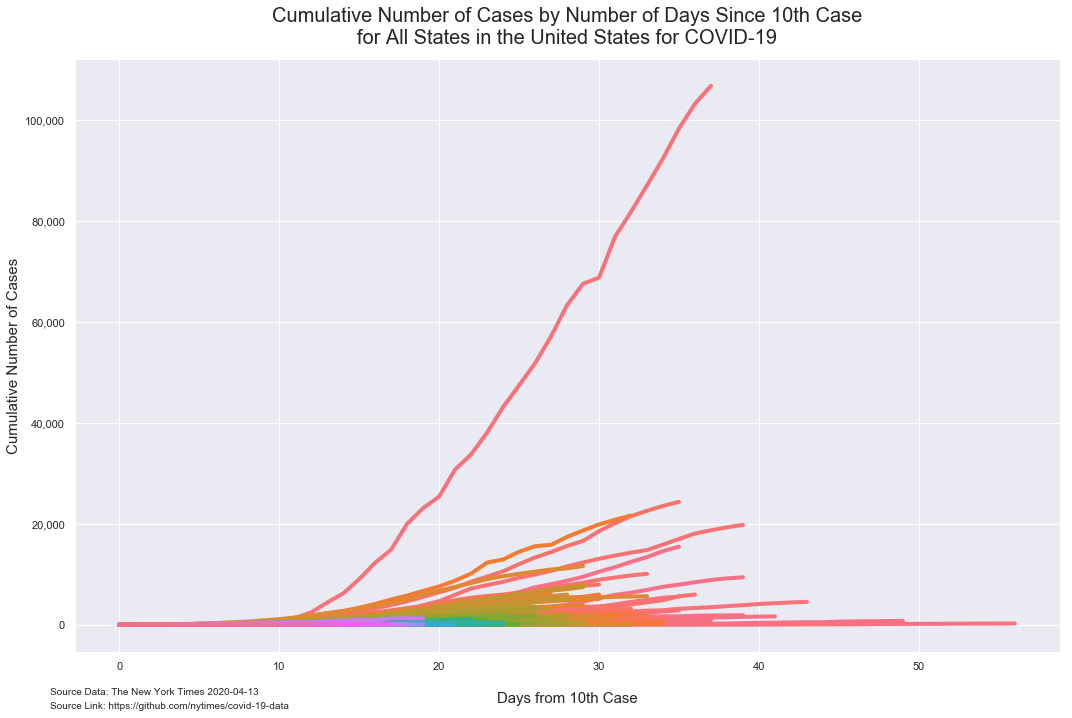

In [82]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Case', fontsize=15)
ax1.set_ylabel('Cumulative Number of Cases', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties')

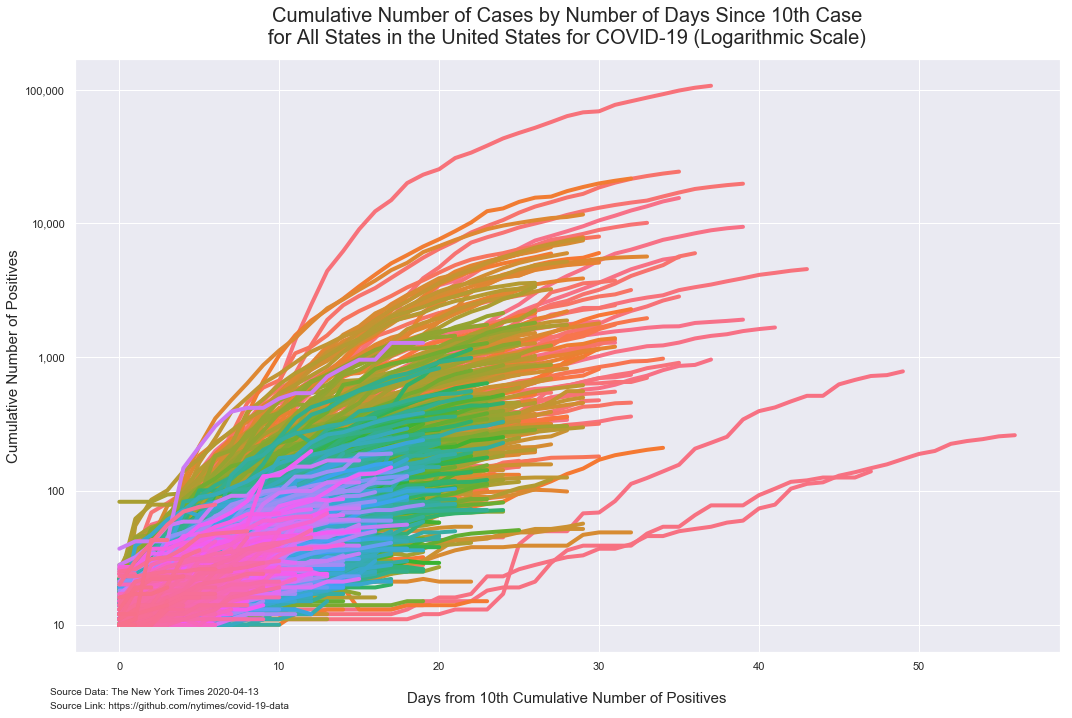

In [83]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="days_from_10_cases", y="cases",
             hue="county_name",
             data=ten_cases_all_states, linewidth=4)
ax1.set_yscale('log')

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.labelpad = 20

ax1.grid(True)
ax1.grid(axis='x', which='minor')

ax1.legend_.remove()
ax1.set_xlabel('Days from 10th Cumulative Number of Positives', fontsize=15)
ax1.set_ylabel('Cumulative Number of Positives', fontsize=15)
plt.title('Cumulative Number of Cases by Number of Days Since 10th Case\nfor All States in the United States for COVID-19 (Logarithmic Scale)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/10-cases-timeseries-all-counties-log')

# Trajectory Plots = daily number (log) vs. total number (log) 

## Daily

In [84]:
trajectory_plot = county_ten_cases.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [85]:
trajectory_plot[:50]

date  county         county_name  cases  daily_cases  deaths  \
211 2020-03-11  Bergen  Bergen, New Jersey     11          1.0       1   
212 2020-03-12  Bergen  Bergen, New Jersey     13          2.0       1   
213 2020-03-13  Bergen  Bergen, New Jersey     17          4.0       1   
214 2020-03-14  Bergen  Bergen, New Jersey     31         14.0       1   
215 2020-03-15  Bergen  Bergen, New Jersey     32          1.0       1   
216 2020-03-16  Bergen  Bergen, New Jersey     61         29.0       2   
217 2020-03-17  Bergen  Bergen, New Jersey     84         23.0       2   
218 2020-03-18  Bergen  Bergen, New Jersey    133         49.0       4   
219 2020-03-19  Bergen  Bergen, New Jersey    297        164.0       6   
220 2020-03-20  Bergen  Bergen, New Jersey    342         45.0       7   
221 2020-03-21  Bergen  Bergen, New Jersey    362         20.0       9   
222 2020-03-22  Bergen  Bergen, New Jersey    457         95.0      10   
223 2020-03-23  Bergen  Bergen, New Jersey    609        152.0      12   
224 2020-03-24  Bergen  Bergen, New Jersey    701         92.0      14   
225 2020-03-25  Bergen  Bergen, New Jersey    819        118.0      15   
226 2020-03-26  Bergen  Bergen, New Jersey   1206        387.0      21   
227 2020-03-27  Bergen  Bergen, New Jersey   1505        299.0      28   
228 2020-03-28  Bergen  Bergen, New Jersey   1838        333.0      35   
229 2020-03-29  Bergen  Bergen, New Jersey   2169        331.0      35   
230 2020-03-30  Bergen  Bergen, New Jersey   2482        313.0      41   
231 2020-03-31  Bergen  Bergen, New Jersey   2909        427.0      53   
232 2020-04-01  Bergen  Bergen, New Jersey   3494        585.0      75   
233 2020-04-02  Bergen  Bergen, New Jersey   4099        605.0     120   
234 2020-04-03  Bergen  Bergen, New Jersey   4866        767.0     132   
235 2020-04-04  Bergen  Bergen, New Jersey   5760        894.0     179   
236 2020-04-05  Bergen  Bergen, New Jersey   6187        427.0     189   
237 2020-04-06  Bergen  Bergen, New Jersey   6862        675.0     200   
238 2020-04-07  Bergen  Bergen, New Jersey   7533        671.0     263   
239 2020-04-08  Bergen  Bergen, New Jersey   7874        341.0     314   
240 2020-04-09  Bergen  Bergen, New Jersey   8343        469.0     345   
241 2020-04-10  Bergen  Bergen, New Jersey   8928        585.0     390   
242 2020-04-11  Bergen  Bergen, New Jersey   9362        434.0     435   
243 2020-04-12  Bergen  Bergen, New Jersey   9784        422.0     453   
244 2020-04-13  Bergen  Bergen, New Jersey  10092        308.0     482   
45  2020-03-09    Cook      Cook, Illinois     11          1.0       0   
46  2020-03-10    Cook      Cook, Illinois     17          6.0       0   
47  2020-03-11    Cook      Cook, Illinois     22          5.0       0   
48  2020-03-12    Cook      Cook, Illinois     27          5.0       0   
49  2020-03-13    Cook      Cook, Illinois     40         13.0       0   
50  2020-03-14    Cook      Cook, Illinois     51         11.0       0   
51  2020-03-15    Cook      Cook, Illinois     76         25.0       0   
52  2020-03-16    Cook      Cook, Illinois     76          0.0       0   
53  2020-03-17    Cook      Cook, Illinois    107         31.0       1   
54  2020-03-18    Cook      Cook, Illinois    179         72.0       1   
55  2020-03-19    Cook      Cook, Illinois    279        100.0       2   
56  2020-03-20    Cook      Cook, Illinois    412        133.0       3   
57  2020-03-21    Cook      Cook, Illinois    548        136.0       4   
58  2020-03-22    Cook      Cook, Illinois    805        257.0       6   
59  2020-03-23    Cook      Cook, Illinois    922        117.0       9   
60  2020-03-24    Cook      Cook, Illinois   1194        272.0      12   

    date_ten_case  days_since_ten_case  
211    2020-03-11                    0  
212    2020-03-11                    1  
213    2020-03-11                    2  
214    2020-03-11                    3  
215    2020-03-11             

/Users/geribauer/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


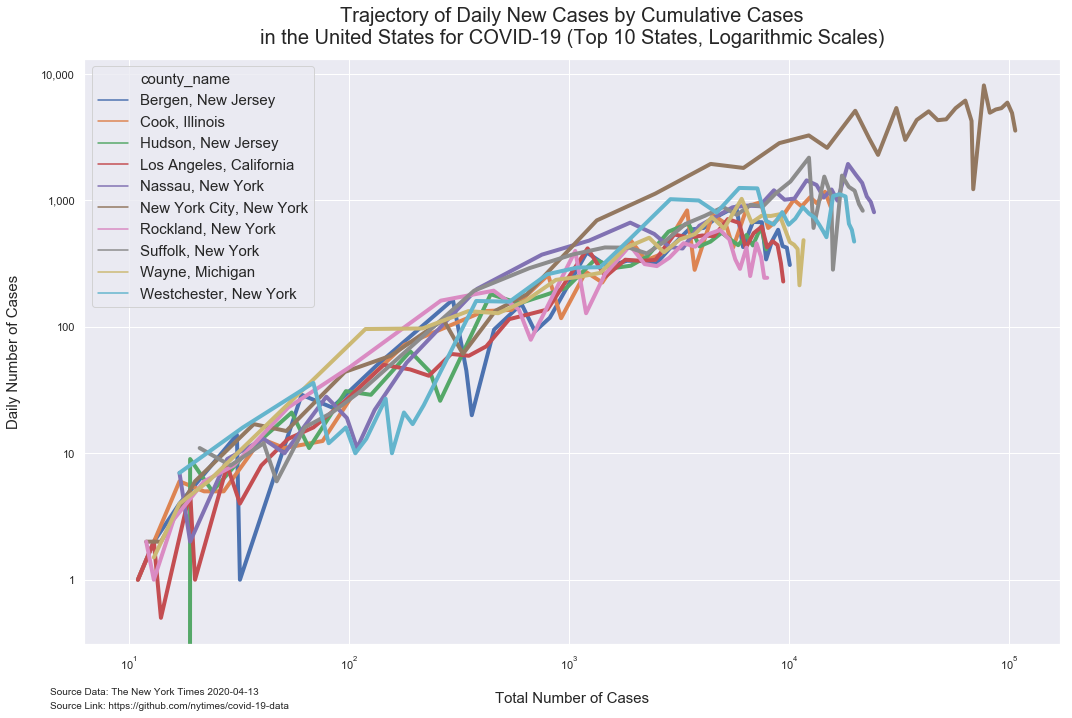

In [86]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases",
             hue="county_name",
             data=trajectory_plot, linewidth=4, ci=False)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-trajectory-daily-plot')

## Weekly

In [87]:
trajectory_plot_weekly = trajectory_plot[['county_name', 'date', 'cases', 'daily_cases']]

In [88]:
trajectory_plot_weekly.head()

county_name       date  cases  daily_cases
211  Bergen, New Jersey 2020-03-11     11          1.0
212  Bergen, New Jersey 2020-03-12     13          2.0
213  Bergen, New Jersey 2020-03-13     17          4.0
214  Bergen, New Jersey 2020-03-14     31         14.0
215  Bergen, New Jersey 2020-03-15     32          1.0

In [89]:
trajectory_plot_weekly = trajectory_plot.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                               'daily_cases': np.mean})

In [90]:
trajectory_plot_weekly

cases  daily_cases
county_name           date                          
Bergen, New Jersey    2020-03-15     32     4.400000
                      2020-03-22    457    60.714286
                      2020-03-29   2169   244.571429
                      2020-04-05   6187   574.000000
                      2020-04-12   9784   513.857143
...                                 ...          ...
Westchester, New York 2020-03-22   1873   239.714286
                      2020-03-29   8519   949.428571
                      2020-04-05  13722   743.285714
                      2020-04-12  19313   798.714286
                      2020-04-19  19785   472.000000

[63 rows x 2 columns]

In [91]:
trajectory_plot_weekly.reset_index(inplace=True)

In [92]:
trajectory_plot_weekly.rename(columns={'daily_cases': 'daily_cases_weekly_average'}, inplace=True)

In [93]:
trajectory_plot_weekly

county_name       date  cases  daily_cases_weekly_average
0      Bergen, New Jersey 2020-03-15     32                    4.400000
1      Bergen, New Jersey 2020-03-22    457                   60.714286
2      Bergen, New Jersey 2020-03-29   2169                  244.571429
3      Bergen, New Jersey 2020-04-05   6187                  574.000000
4      Bergen, New Jersey 2020-04-12   9784                  513.857143
..                    ...        ...    ...                         ...
58  Westchester, New York 2020-03-22   1873                  239.714286
59  Westchester, New York 2020-03-29   8519                  949.428571
60  Westchester, New York 2020-04-05  13722                  743.285714
61  Westchester, New York 2020-04-12  19313                  798.714286
62  Westchester, New York 2020-04-19  19785                  472.000000

[63 rows x 4 columns]

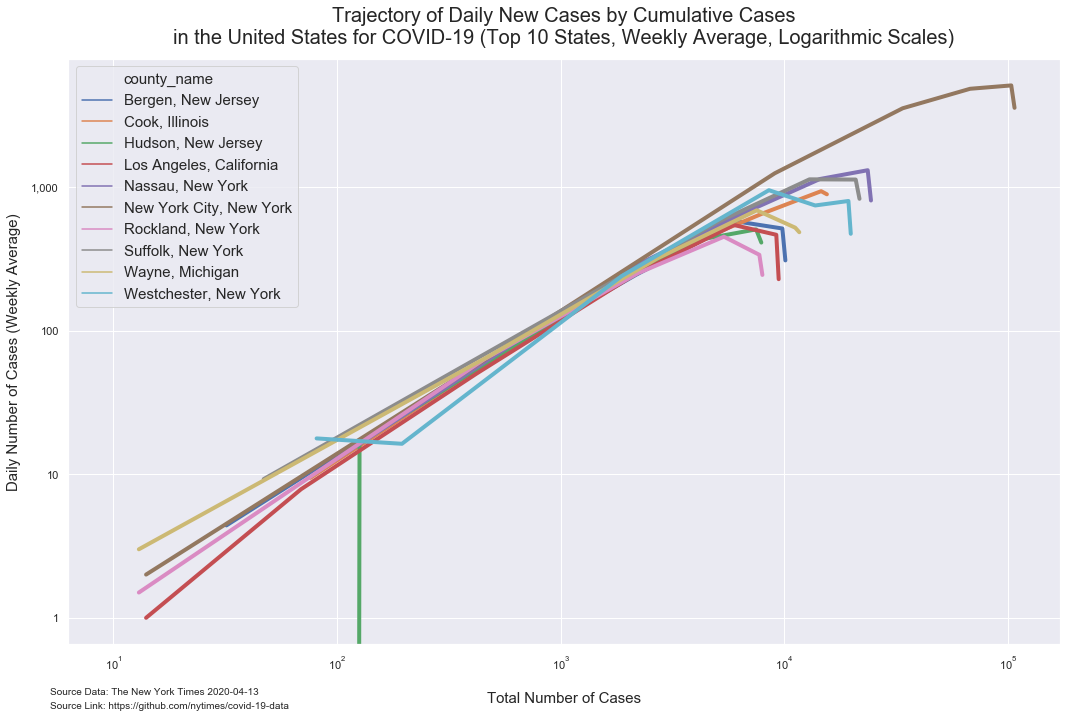

In [94]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 10

ax1.legend(fontsize=15)
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Top 10 States, Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/county-trajectory-weekly-plot')

In [95]:
trajectory_plot_weekly_scatter = trajectory_plot_weekly.sort_values(by=['date', 'cases'], 
                                              ascending=[False, False]).drop_duplicates(subset ="county_name", 
                                                                                        keep = 'first').reset_index(drop=True)

In [96]:
trajectory_plot_weekly_scatter

county_name       date   cases  daily_cases_weekly_average
0  New York City, New York 2020-04-19  106764                      3556.0
1         Nassau, New York 2020-04-19   24358                       805.0
2        Suffolk, New York 2020-04-19   21643                       827.0
3    Westchester, New York 2020-04-19   19785                       472.0
4           Cook, Illinois 2020-04-19   15474                       889.0
5          Wayne, Michigan 2020-04-19   11648                       484.0
6       Bergen, New Jersey 2020-04-19   10092                       308.0
7  Los Angeles, California 2020-04-19    9420                       228.0
8       Rockland, New York 2020-04-19    7965                       244.0
9       Hudson, New Jersey 2020-04-19    7879                       410.0

In [97]:
len(trajectory_plot_weekly_scatter)

10

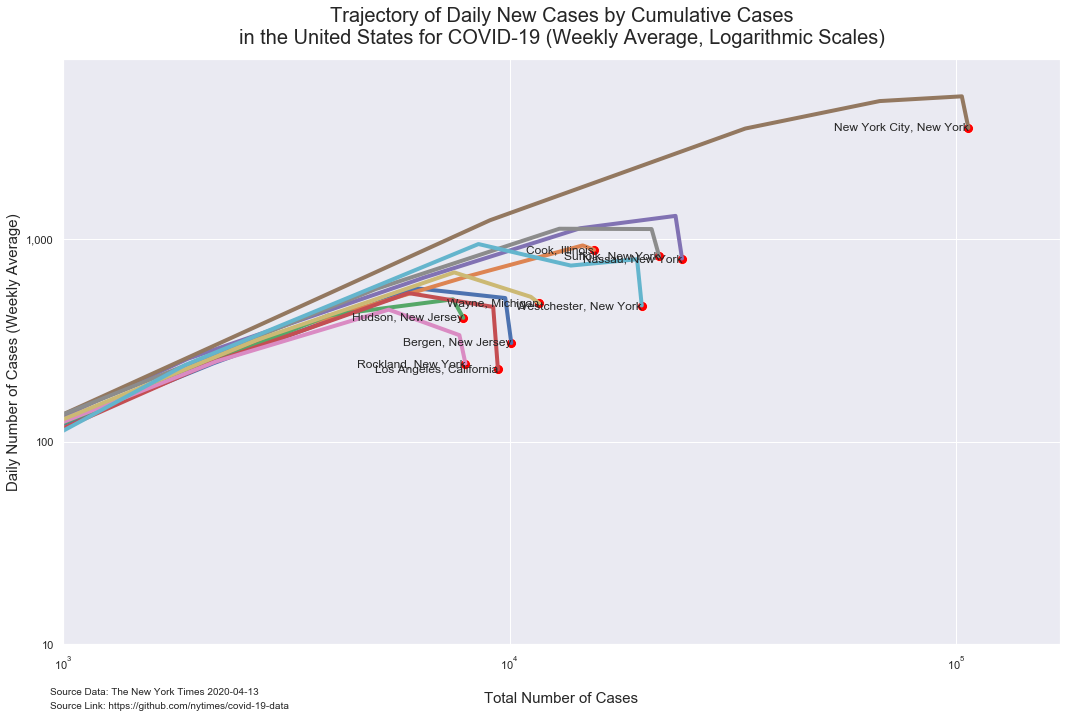

In [98]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_weekly_average",
             hue="county_name",
             data=trajectory_plot_weekly, linewidth=4)

sns.scatterplot(x="cases", y="daily_cases_weekly_average", 
             data=trajectory_plot_weekly_scatter, s=100, ax=ax1, color='red')


x = trajectory_plot_weekly_scatter.daily_cases_weekly_average
z = trajectory_plot_weekly_scatter.cases
n = trajectory_plot_weekly_scatter.county_name
for i, label in enumerate(n):
    ax1.annotate(label, (z[i], x[i]), fontsize=12,
                 horizontalalignment='right', va='center', clip_on=True)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5
plt.xlim(1000)
plt.ylim(10)

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot-labels')

# Trajectory for All Counties

In [99]:
trajectory_all_counties = covid_19_counties_data.sort_values(by=['county_name', 'date','cases'], 
                                ascending=[True, True, True])

In [100]:
trajectory_all_counties

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
...          ...        ...             ...      ...    ...     ...   
45558 2020-04-09     Zapata           Texas  48505.0      1       0   
48182 2020-04-10     Zapata           Texas  48505.0      3       0   
50838 2020-04-11     Zapata           Texas  48505.0      3       0   
53514 2020-04-12     Zapata           Texas  48505.0      3       0   
56205 2020-04-13     Zapata           Texas  48505.0      3       0   

                     county_name  
5000   Abbeville, South Carolina  
5873   Abbeville, South Carolina  
6877   Abbeville, South Carolina  
7997   Abbeville, South Carolina  
9209   Abbeville, South Carolina  
...                          ...  
45558              Zapata, Texas  
48182              Zapata, Texas  
50838              Zapata, Texas  
53514              Zapata, Texas  
56205              Zapata, Texas  

[55864 rows x 7 columns]

In [101]:
trajectory_all_counties['daily_cases'] = trajectory_all_counties['cases'].diff()

In [102]:
trajectory_all_counties[150:200]

date county     state     fips  cases  deaths      county_name  \
20759 2020-03-30  Adair  Missouri  29001.0      2       0  Adair, Missouri   
22895 2020-03-31  Adair  Missouri  29001.0      2       0  Adair, Missouri   
25090 2020-04-01  Adair  Missouri  29001.0      3       0  Adair, Missouri   
27346 2020-04-02  Adair  Missouri  29001.0      6       0  Adair, Missouri   
29663 2020-04-03  Adair  Missouri  29001.0      8       0  Adair, Missouri   
32044 2020-04-04  Adair  Missouri  29001.0     10       0  Adair, Missouri   
34475 2020-04-05  Adair  Missouri  29001.0     10       0  Adair, Missouri   
36941 2020-04-06  Adair  Missouri  29001.0     10       0  Adair, Missouri   
39451 2020-04-07  Adair  Missouri  29001.0     11       0  Adair, Missouri   
42001 2020-04-08  Adair  Missouri  29001.0     11       0  Adair, Missouri   
44571 2020-04-09  Adair  Missouri  29001.0     11       0  Adair, Missouri   
47179 2020-04-10  Adair  Missouri  29001.0     11       0  Adair, Missouri   
49825 2020-04-11  Adair  Missouri  29001.0     11       0  Adair, Missouri   
52498 2020-04-12  Adair  Missouri  29001.0     11       0  Adair, Missouri   
55180 2020-04-13  Adair  Missouri  29001.0     11       0  Adair, Missouri   
11917 2020-03-25  Adair  Oklahoma  40001.0      2       0  Adair, Oklahoma   
13537 2020-03-26  Adair  Oklahoma  40001.0      2       0  Adair, Oklahoma   
15285 2020-03-27  Adair  Oklahoma  40001.0      3       0  Adair, Oklahoma   
17141 2020-03-28  Adair  Oklahoma  40001.0      3       0  Adair, Oklahoma   
19089 2020-03-29  Adair  Oklahoma  40001.0      4       0  Adair, Oklahoma   
21146 2020-03-30  Adair  Oklahoma  40001.0      4       0  Adair, Oklahoma   
23296 2020-03-31  Adair  Oklahoma  40001.0      4       0  Adair, Oklahoma   
25502 2020-04-01  Adair  Oklahoma  40001.0      8       0  Adair, Oklahoma   
27770 2020-04-02  Adair  Oklahoma  40001.0      9       0  Adair, Oklahoma   
30098 2020-04-03  Adair  Oklahoma  40001.0     14       0  Adair, Oklahoma   
32489 2020-04-04  Adair  Oklahoma  40001.0     14       0  Adair, Oklahoma   
34925 2020-04-05  Adair  Oklahoma  40001.0     18       0  Adair, Oklahoma   
37402 2020-04-06  Adair  Oklahoma  40001.0     20       0  Adair, Oklahoma   
39917 2020-04-07  Adair  Oklahoma  40001.0     25       1  Adair, Oklahoma   
42473 2020-04-08  Adair  Oklahoma  40001.0     25       2  Adair, Oklahoma   
45052 2020-04-09  Adair  Oklahoma  40001.0     25       2  Adair, Oklahoma   
47668 2020-04-10  Adair  Oklahoma  40001.0     26       2  Adair, Oklahoma   
50323 2020-04-11  Adair  Oklahoma  40001.0     27       2  Adair, Oklahoma   
52996 2020-04-12  Adair  Oklahoma  40001.0     27       2  Adair, Oklahoma   
55682 2020-04-13  Adair  Oklahoma  40001.0     27       2  Adair, Oklahoma   
1395  2020-03-12  Adams  Colorado   8001.0      2       0  Adams, Colorado   
1656  2020-03-13  Adams  Colorado   8001.0      3       0  Adams, Colorado   
1974  2020-03-14  Adams  Colorado   8001.0      6       0  Adams, Colorado   
2355  2020-03-15  Adams  Colorado   8001.0      6       0  Adams, Colorado   
2790  2020-03-16  Adams  Colorado   8001.0      8       0  Adams, Colorado   
3272  2020-03-17  Adams  Colorado   8001.0     10       0  Adams, Colorado   
3826  2020-03-18  Adams  Colorado   8001.0     10       0  Adams, Colorado   
4486  2020-03-19  Adams  Colorado   8001.0     10       0  Adams, Colorado   
5261  2020-03-20  Adams  Colorado   8001.0     12       0  Adams, Colorado   
6184  2020-03-21  Adams  Colorado   8001.0     14       0  Adams, Colorado   
7219  2020-03-22  Adams  Colorado   8001.0     18       0  Adams, Colorado   
8362  2020-03-23  Adams  Colorado   8001.0     25       0  Adams, Colorado   
9606  2020-03-24  Adams  Colorado   8001.0     27       0  Adams, Colorado   
10982 2020-03-25  Adams  Colorado   8001.0     38       0  Adams, Colorado   
12533 2020-03-26  Adams  Colorado   8001.0     50       0  Adams, Colorado   

       daily_cases  
20759       

In [103]:
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases < 0] = trajectory_all_counties.cases
trajectory_all_counties['daily_cases'].loc[trajectory_all_counties.daily_cases.isnull()] = trajectory_all_counties.cases

In [104]:
trajectory_all_counties[:50]

date     county           state     fips  cases  deaths  \
5000  2020-03-19  Abbeville  South Carolina  45001.0      1       0   
5873  2020-03-20  Abbeville  South Carolina  45001.0      1       0   
6877  2020-03-21  Abbeville  South Carolina  45001.0      1       0   
7997  2020-03-22  Abbeville  South Carolina  45001.0      1       0   
9209  2020-03-23  Abbeville  South Carolina  45001.0      1       0   
10539 2020-03-24  Abbeville  South Carolina  45001.0      1       0   
12015 2020-03-25  Abbeville  South Carolina  45001.0      3       0   
13647 2020-03-26  Abbeville  South Carolina  45001.0      4       0   
15404 2020-03-27  Abbeville  South Carolina  45001.0      4       0   
17268 2020-03-28  Abbeville  South Carolina  45001.0      4       0   
19222 2020-03-29  Abbeville  South Carolina  45001.0      4       0   
21283 2020-03-30  Abbeville  South Carolina  45001.0      3       0   
23436 2020-03-31  Abbeville  South Carolina  45001.0      4       0   
25643 2020-04-01  Abbeville  South Carolina  45001.0      4       0   
27916 2020-04-02  Abbeville  South Carolina  45001.0      6       0   
30251 2020-04-03  Abbeville  South Carolina  45001.0      6       0   
32644 2020-04-04  Abbeville  South Carolina  45001.0      6       0   
35083 2020-04-05  Abbeville  South Carolina  45001.0      6       0   
37561 2020-04-06  Abbeville  South Carolina  45001.0      6       0   
40081 2020-04-07  Abbeville  South Carolina  45001.0      5       0   
42637 2020-04-08  Abbeville  South Carolina  45001.0      6       0   
45216 2020-04-09  Abbeville  South Carolina  45001.0      7       0   
47833 2020-04-10  Abbeville  South Carolina  45001.0      7       0   
50489 2020-04-11  Abbeville  South Carolina  45001.0      9       0   
53162 2020-04-12  Abbeville  South Carolina  45001.0      9       0   
55849 2020-04-13  Abbeville  South Carolina  45001.0      9       0   
7518  2020-03-22     Acadia       Louisiana  22001.0      1       0   
8681  2020-03-23     Acadia       Louisiana  22001.0      1       0   
9973  2020-03-24     Acadia       Louisiana  22001.0      2       0   
11381 2020-03-25     Acadia       Louisiana  22001.0      2       0   
12963 2020-03-26     Acadia       Louisiana  22001.0      3       0   
14680 2020-03-27     Acadia       Louisiana  22001.0      8       1   
16507 2020-03-28     Acadia       Louisiana  22001.0      9       1   
18432 2020-03-29     Acadia       Louisiana  22001.0      9       1   
20461 2020-03-30     Acadia       Louisiana  22001.0     11       1   
22586 2020-03-31     Acadia       Louisiana  22001.0     39       1   
24774 2020-04-01     Acadia       Louisiana  22001.0     47       1   
27029 2020-04-02     Acadia       Louisiana  22001.0     61       1   
29341 2020-04-03     Acadia       Louisiana  22001.0     72       1   
31721 2020-04-04     Acadia       Louisiana  22001.0     65       2   
34147 2020-04-05     Acadia       Louisiana  22001.0     75       2   
36609 2020-04-06     Acadia       Louisiana  22001.0     79       2   
39115 2020-04-07     Acadia       Louisiana  22001.0     82       2   
41664 2020-04-08     Acadia       Louisiana  22001.0     86       2   
44233 2020-04-09     Acadia       Louisiana  22001.0     89       3   
46839 2020-04-10     Acadia       Louisiana  22001.0     94       4   
49480 2020-04-11     Acadia       Louisiana  22001.0     98       4   
52150 2020-04-12     Acadia       Louisiana  22001.0     99       5   
54831 2020-04-13     Acadia       Louisiana  22001.0    101       5   
5987  2020-03-20   Accomack        Virginia  51001.0      1       0   

                     county_name  daily_cases  
5000   Abbeville, South Carolina          1.0  
5873   Abbeville, South Carolina          0.0  
6877   Abbeville, South Carolina          0.0  
7997   Abbeville, South Carolina          0.0  
9209   Abbeville, South Carolina          0.0  
10539  Abbeville, South Carolina          0.0  
12015  Abbeville, South Carolina          2.0  
13647 

In [105]:
trajectory_all_counties = trajectory_all_counties.set_index('date').groupby('county_name').resample('W').agg({'cases': np.max, 
                                                                                                    'daily_cases': np.mean})
trajectory_all_counties.reset_index(inplace=True)
trajectory_all_counties.rename(columns={'daily_cases': 'daily_cases_week_avg'}, inplace=True)

In [106]:
trajectory_all_counties.head()

county_name       date  cases  daily_cases_week_avg
0  Abbeville, South Carolina 2020-03-22    1.0              0.250000
1  Abbeville, South Carolina 2020-03-29    4.0              0.428571
2  Abbeville, South Carolina 2020-04-05    6.0              0.857143
3  Abbeville, South Carolina 2020-04-12    9.0              1.285714
4  Abbeville, South Carolina 2020-04-19    9.0              0.000000

In [107]:
temp_fill_zeros = trajectory_all_counties.sort_values(by=['county_name', 'date','cases'], 
                                                 ascending=[True, True, True])

temp_fill_zeros['cases'].loc[temp_fill_zeros.cases < 1] = 1
temp_fill_zeros['daily_cases_week_avg'].loc[temp_fill_zeros.daily_cases_week_avg < 1] = 1

temp_fill_zeros

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19    9.0              1.000000
...                          ...        ...    ...                   ...
11446             Yuma, Colorado 2020-04-05    2.0              1.000000
11447             Yuma, Colorado 2020-04-12    2.0              1.000000
11448             Yuma, Colorado 2020-04-19    2.0              1.000000
11449              Zapata, Texas 2020-04-12    3.0              1.000000
11450              Zapata, Texas 2020-04-19    3.0              1.000000

[11451 rows x 4 columns]

In [108]:
temp_fill_zeros.loc[temp_fill_zeros.cases.isnull() == True]

county_name       date  cases  daily_cases_week_avg
2789       Decatur, Tennessee 2020-04-05    NaN                   NaN
4943  Jackson, North Carolina 2020-04-12    NaN                   NaN

In [109]:
temp_fill_zeros.dropna()

county_name       date  cases  daily_cases_week_avg
0      Abbeville, South Carolina 2020-03-22    1.0              1.000000
1      Abbeville, South Carolina 2020-03-29    4.0              1.000000
2      Abbeville, South Carolina 2020-04-05    6.0              1.000000
3      Abbeville, South Carolina 2020-04-12    9.0              1.285714
4      Abbeville, South Carolina 2020-04-19    9.0              1.000000
...                          ...        ...    ...                   ...
11446             Yuma, Colorado 2020-04-05    2.0              1.000000
11447             Yuma, Colorado 2020-04-12    2.0              1.000000
11448             Yuma, Colorado 2020-04-19    2.0              1.000000
11449              Zapata, Texas 2020-04-12    3.0              1.000000
11450              Zapata, Texas 2020-04-19    3.0              1.000000

[11449 rows x 4 columns]

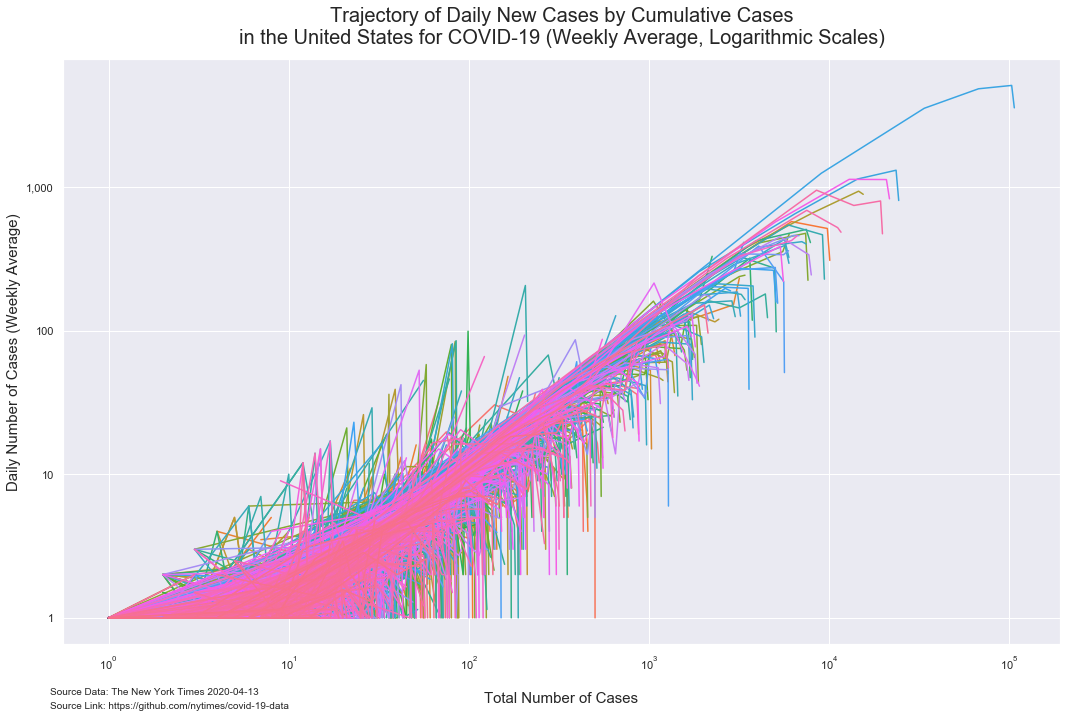

In [110]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases_week_avg",
             hue="county_name",
             data=temp_fill_zeros, ci=False)
                
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 5

ax1.legend_.remove()
ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of Daily New Cases by Cumulative Cases\nin the United States for COVID-19 (Weekly Average, Logarithmic Scales)', pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/all-counties-trajectory-weekly-plot')

# Timeseries for USA

In [111]:
g = covid_19_counties_data.groupby('date')['cases'].sum().reset_index()

g.set_index('date', drop=False, inplace=True)

g.index = pd.to_datetime(g.index, infer_datetime_format=True)

In [112]:
g.index.dtype

dtype('<M8[ns]')

In [113]:
g.head()

date  cases
date                        
2020-01-21 2020-01-21      1
2020-01-22 2020-01-22      1
2020-01-23 2020-01-23      1
2020-01-24 2020-01-24      2
2020-01-25 2020-01-25      3

In [114]:
g.tail()

date   cases
date                         
2020-04-09 2020-04-09  457854
2020-04-10 2020-04-10  490996
2020-04-11 2020-04-11  521854
2020-04-12 2020-04-12  548539
2020-04-13 2020-04-13  574011

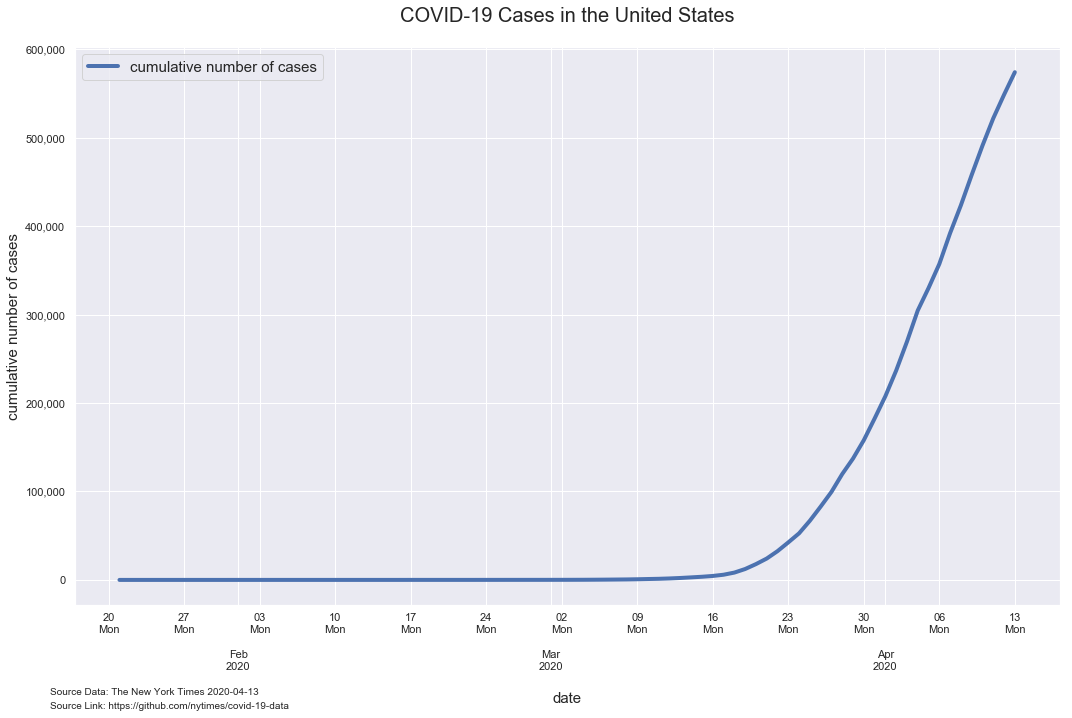

In [117]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax1.plot(g['cases'], linewidth=4)

ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.set_ylabel('cumulative number of cases', fontsize=15)

ax1.grid(True)
ax1.grid(which='minor')

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-linear')

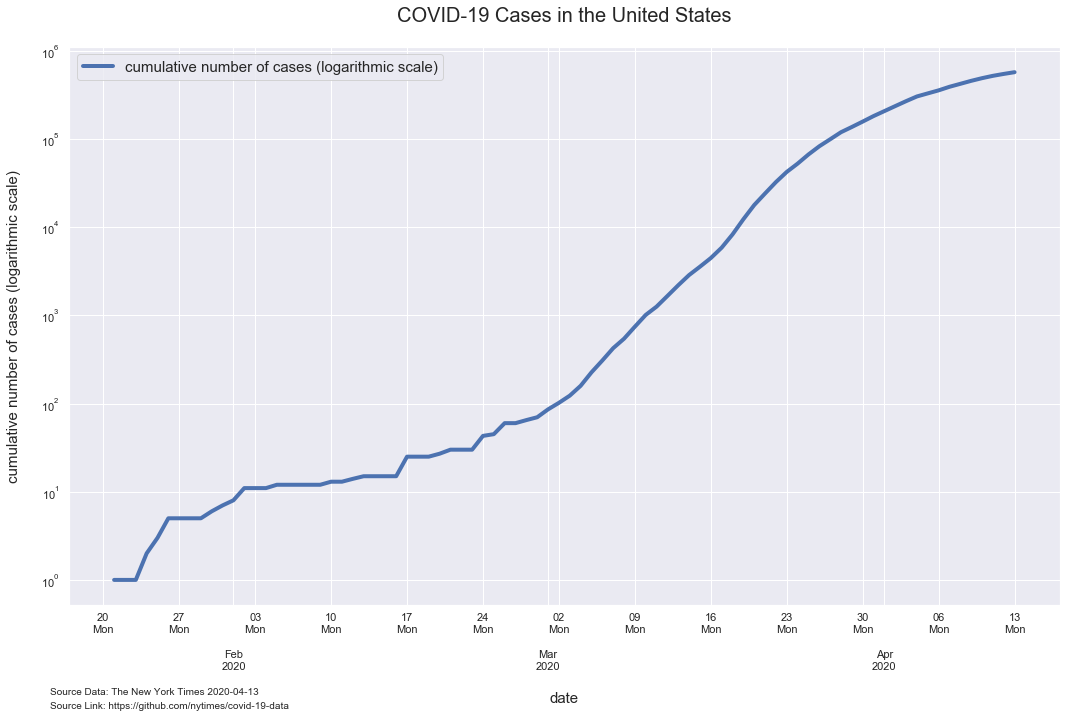

In [118]:
fig, ax2 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

ax2.plot(g['cases'], linewidth=4)

ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, labelpad = 20)

ax2.grid(True)
ax2.grid(which='minor', axis='x')

ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=0, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

ax2.set_yscale('log')
plt.tight_layout()
plt.savefig('figures/counties-log')

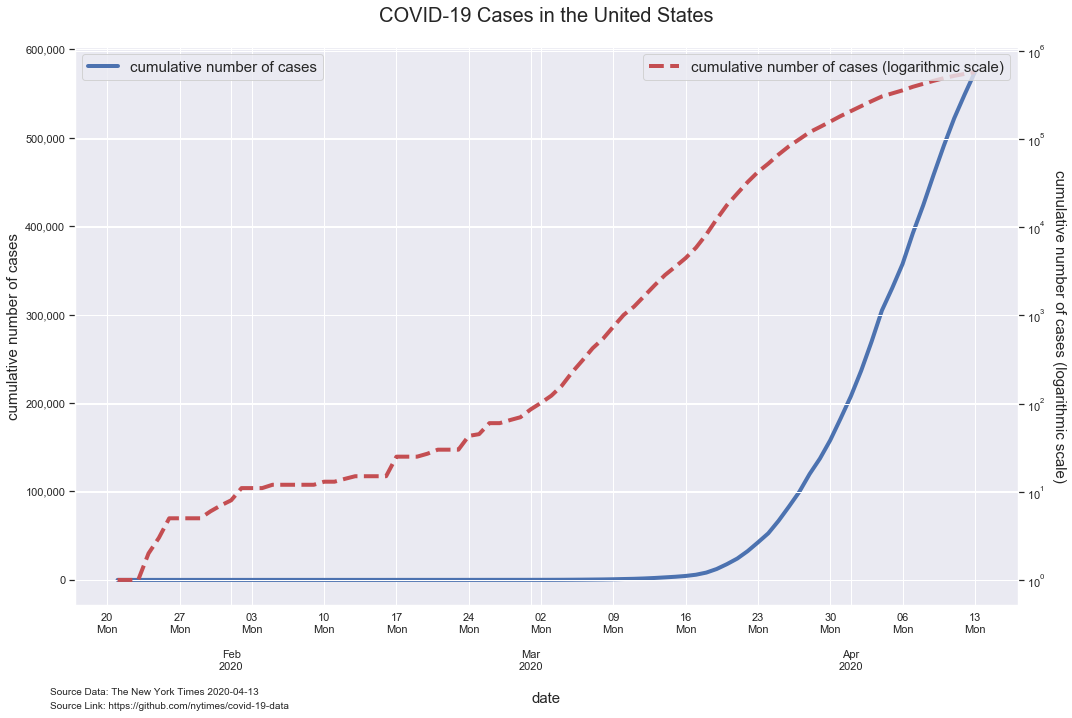

In [119]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)

# Plot 2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')

ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.set_xlabel('date', fontsize=15, labelpad = 20)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')

ax1.grid(True)
ax1.grid(which='minor')
ax2.tick_params(axis='both', which='minor', length=0)
plt.setp(ax2.get_yticklabels(), visible=True)

ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)
plt.title('COVID-19 Cases in the United States', pad = 25, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-timeseries-overlay')

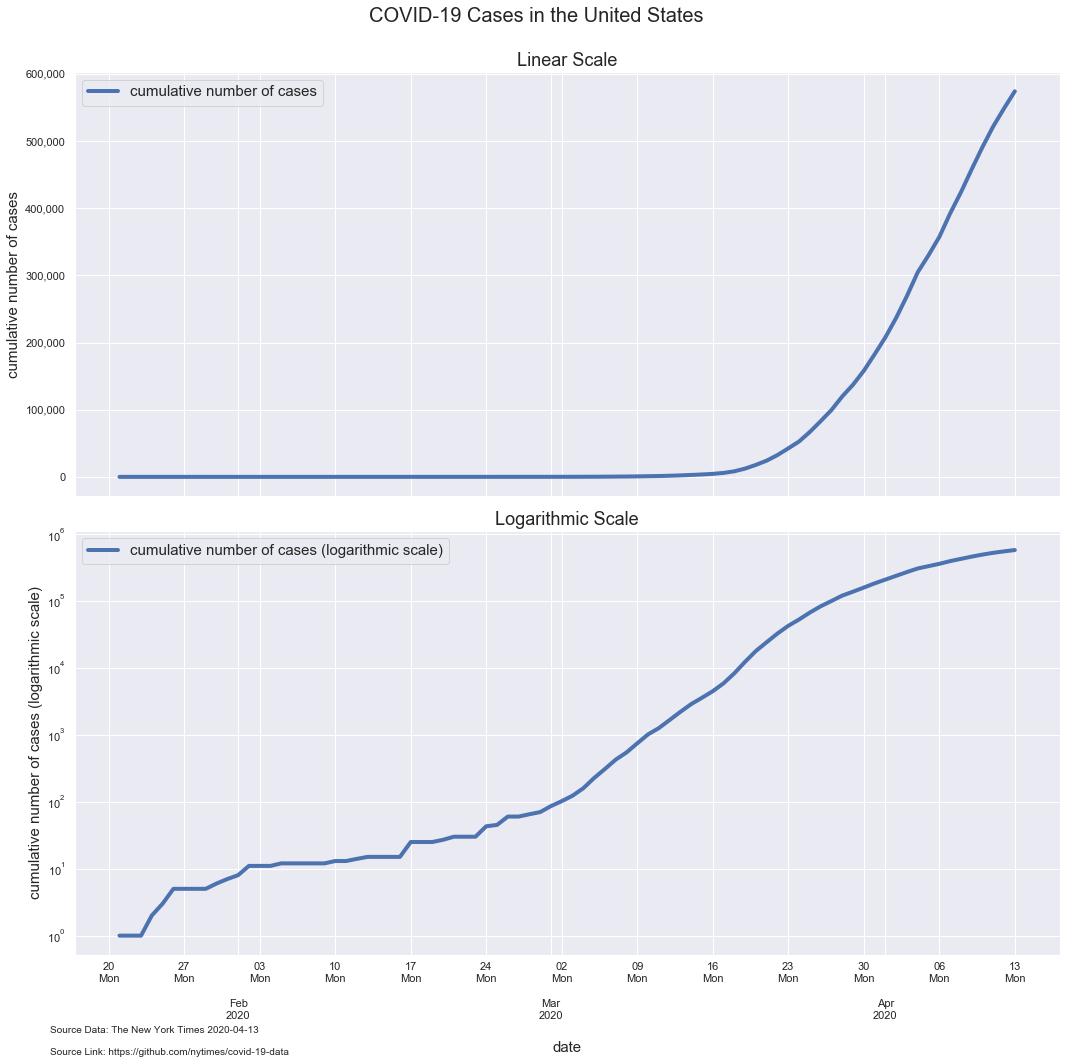

In [120]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')

# Plot 2
ax2.plot(g['cases'], linewidth=4)
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax2.set_xlabel('date', fontsize=15, labelpad = 20)
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax2.grid(True)
ax2.grid(which='minor', axis='x')

# Formatting Figure
ax1.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=15)
ax1.set_title('Linear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax2.set_yscale('log')

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.savefig('figures/counties-timeseries-2-subplots')

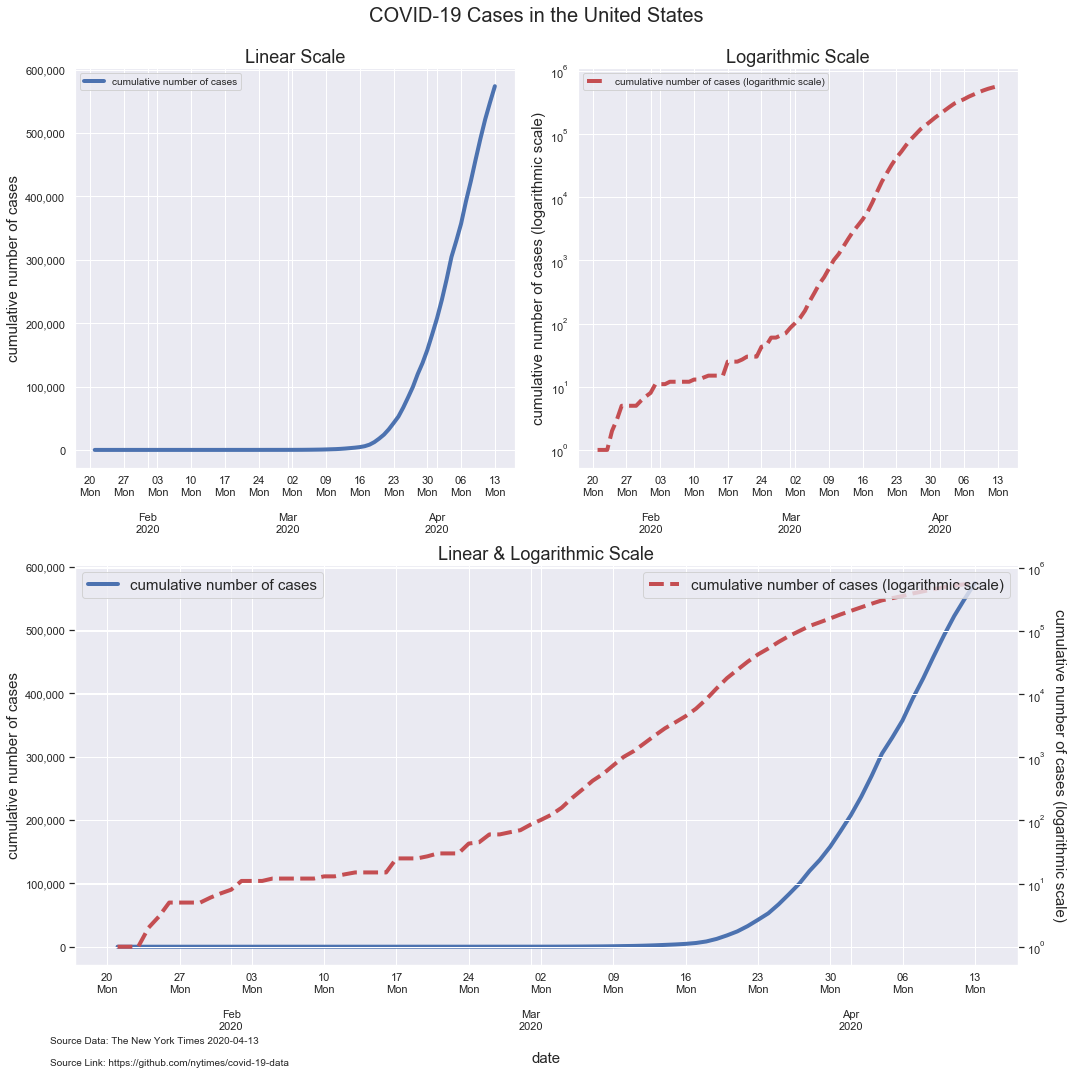

In [121]:
fig, [ax1, ax2, ax3, ax3_1] = plt.subplots(4, 1, sharex=True, figsize=(15,15))
fig.suptitle('COVID-19 Cases in the United States', y = .99, fontsize=20)
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

# Plot 1
ax3 = plt.subplot(212)
ax3.plot(g['cases'], linewidth=4)
ax3.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3.set_xlabel('Date', fontsize=15, labelpad = 20)
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
ax3_1.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax3_1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax3_1.xaxis.grid(True, which="major")
ax3_1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax3_1.set_yscale('log')

ax3.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax3.xaxis.grid(True, which="major")
ax3.xaxis.set_major_locator(dates.MonthLocator())
ax3.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Plot 2
ax1 = plt.subplot(221)
ax1.plot(g['cases'], linewidth=4)
ax1.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax1.xaxis.grid(True, which="major")
ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))


# Plot 3
ax2 = plt.subplot(222)
ax2.plot(g['cases'], linewidth=4, color='r', linestyle='dashed')
ax2.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0), interval=1))

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax2.xaxis.grid(True, which="major")
ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))

# Formatting Grid
ax1.grid(True)
ax1.grid(which='minor')
ax2.grid(True)
ax2.grid(which='minor', axis='x')
ax3.grid(True)
ax3.grid(which='minor')
ax3_1.grid(True)
ax3_1.grid(which='minor', axis='x')
ax3_1.tick_params(axis='both', which='minor', length=0)

# Setting Labels
ax1.set_ylabel('cumulative number of cases', fontsize=15)
ax2.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15)
ax3.set_ylabel('cumulative number of cases', fontsize=15)
ax3.set_xlabel('date', fontsize=15, labelpad = 20)
ax3_1.set_ylabel('cumulative number of cases (logarithmic scale)', fontsize=15, rotation = 270, labelpad = 20)
ax2.get_yaxis().set_visible(True)
ax2.set_yscale('log')
ax2.get_yaxis().set_visible(True)
ax3_1.get_yaxis().set_visible(True)
ax3_1.set_yscale('log')
ax3_1.get_yaxis().set_visible(True)

# Setting Titles
ax1.set_title('\n\nLinear Scale', fontsize=18)
ax2.set_title('Logarithmic Scale', fontsize=18)
ax3.set_title('Linear & Logarithmic Scale', fontsize=18)

# Setting Legends
ax1.legend(['cumulative number of cases'], loc=2, fontsize=10)
ax2.legend(['cumulative number of cases (logarithmic scale)'], loc=2, fontsize=10)
ax3.legend(['cumulative number of cases'], loc=2, fontsize=15)
ax3_1.legend(['cumulative number of cases (logarithmic scale)'], loc=1, fontsize=15)

plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/counties-3-subplots')

# Country Trajectory Plot

In [122]:
g['daily_cases'] = g['cases'].diff()

In [123]:
g.head(20)

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          NaN
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0

In [124]:
g['daily_cases'].loc[g.daily_cases < 0] = g.cases
g['daily_cases'].loc[g.daily_cases.isnull()] = g.cases

In [125]:
g[:50]

date  cases  daily_cases
date                                     
2020-01-21 2020-01-21      1          1.0
2020-01-22 2020-01-22      1          0.0
2020-01-23 2020-01-23      1          0.0
2020-01-24 2020-01-24      2          1.0
2020-01-25 2020-01-25      3          1.0
2020-01-26 2020-01-26      5          2.0
2020-01-27 2020-01-27      5          0.0
2020-01-28 2020-01-28      5          0.0
2020-01-29 2020-01-29      5          0.0
2020-01-30 2020-01-30      6          1.0
2020-01-31 2020-01-31      7          1.0
2020-02-01 2020-02-01      8          1.0
2020-02-02 2020-02-02     11          3.0
2020-02-03 2020-02-03     11          0.0
2020-02-04 2020-02-04     11          0.0
2020-02-05 2020-02-05     12          1.0
2020-02-06 2020-02-06     12          0.0
2020-02-07 2020-02-07     12          0.0
2020-02-08 2020-02-08     12          0.0
2020-02-09 2020-02-09     12          0.0
2020-02-10 2020-02-10     13          1.0
2020-02-11 2020-02-11     13          0.0
2020-02-12 2020-02-12     14          1.0
2020-02-13 2020-02-13     15          1.0
2020-02-14 2020-02-14     15          0.0
2020-02-15 2020-02-15     15          0.0
2020-02-16 2020-02-16     15          0.0
2020-02-17 2020-02-17     25         10.0
2020-02-18 2020-02-18     25          0.0
2020-02-19 2020-02-19     25          0.0
2020-02-20 2020-02-20     27          2.0
2020-02-21 2020-02-21     30          3.0
2020-02-22 2020-02-22     30          0.0
2020-02-23 2020-02-23     30          0.0
2020-02-24 2020-02-24     43         13.0
2020-02-25 2020-02-25     45          2.0
2020-02-26 2020-02-26     60         15.0
2020-02-27 2020-02-27     60          0.0
2020-02-28 2020-02-28     65          5.0
2020-02-29 2020-02-29     70          5.0
2020-03-01 2020-03-01     86         16.0
2020-03-02 2020-03-02    102         16.0
2020-03-03 2020-03-03    123         21.0
2020-03-04 2020-03-04    159         36.0
2020-03-05 2020-03-05    226         67.0
2020-03-06 2020-03-06    308         82.0
2020-03-07 2020-03-07    425        117.0
2020-03-08 2020-03-08    544        119.0
2020-03-09 2020-03-09    745        201.0
2020-03-10 2020-03-10   1013        268.0

In [126]:
g_weekly = g.set_index('date').resample('W').agg({'cases': np.max, 'daily_cases': np.mean})

In [127]:
g_weekly

cases   daily_cases
date                            
2020-01-26       5      0.833333
2020-02-02      11      0.857143
2020-02-09      12      0.142857
2020-02-16      15      0.428571
2020-02-23      30      2.142857
2020-03-01      86      8.000000
2020-03-08     544     65.428571
2020-03-15    3570    432.285714
2020-03-22   32521   4135.857143
2020-03-29  137191  14952.857143
2020-04-05  329966  27539.285714
2020-04-12  548539  31224.714286
2020-04-19  574011  25472.000000

In [128]:
g_weekly.reset_index(inplace=True)
g_weekly.rename(columns={'cases_diff': 'cases_daily_week_avg'}, inplace=True)

In [129]:
g_weekly

date   cases   daily_cases
0  2020-01-26       5      0.833333
1  2020-02-02      11      0.857143
2  2020-02-09      12      0.142857
3  2020-02-16      15      0.428571
4  2020-02-23      30      2.142857
5  2020-03-01      86      8.000000
6  2020-03-08     544     65.428571
7  2020-03-15    3570    432.285714
8  2020-03-22   32521   4135.857143
9  2020-03-29  137191  14952.857143
10 2020-04-05  329966  27539.285714
11 2020-04-12  548539  31224.714286
12 2020-04-19  574011  25472.000000

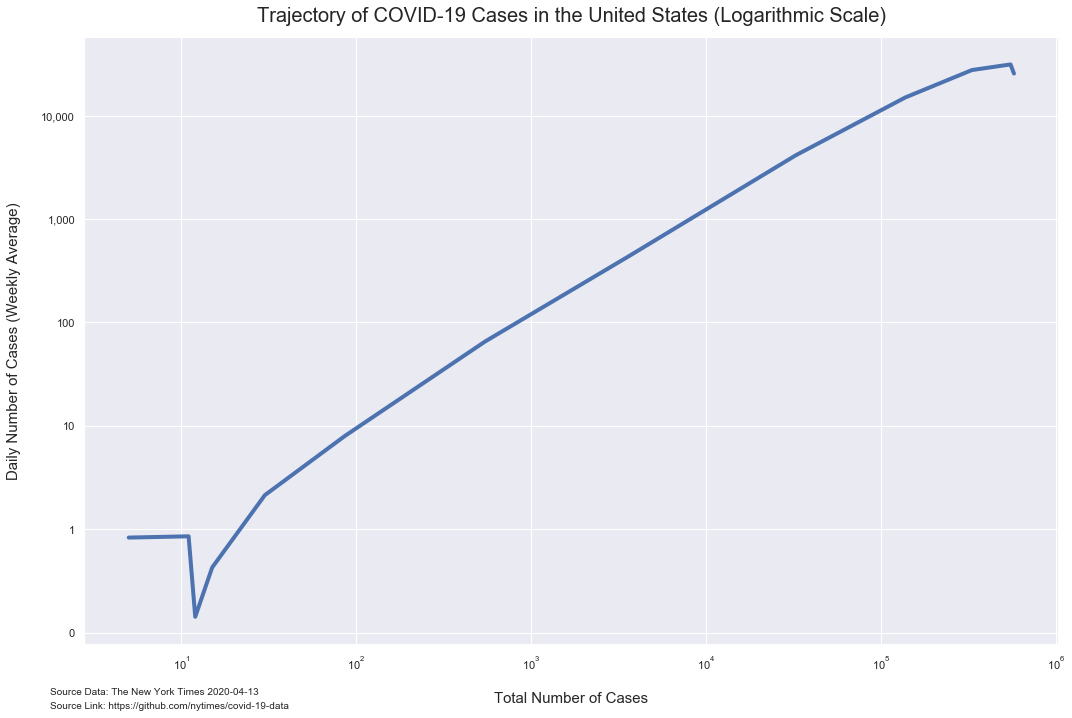

In [130]:
fig, ax1 = plt.subplots(figsize=(15,10))
txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')

sns.lineplot(x="cases", y="daily_cases", data=g_weekly, linewidth=4)
ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.xaxis.grid(True, which="major")
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.xaxis.labelpad = 20
ax1.yaxis.labelpad = 20

ax1.set_xlabel('Total Number of Cases', fontsize=15)
ax1.set_ylabel('Daily Number of Cases (Weekly Average)', fontsize=15)
plt.title('Trajectory of COVID-19 Cases in the United States (Logarithmic Scale)', 
          pad = 15, fontsize=20)
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()
plt.savefig('figures/usa-counties-trajectory-weekly-plot')

# Bar Chart

In [131]:
covid_19_counties_data

date      county       state     fips  cases  deaths  \
0     2020-01-21   Snohomish  Washington  53061.0      1       0   
1     2020-01-22   Snohomish  Washington  53061.0      1       0   
2     2020-01-23   Snohomish  Washington  53061.0      1       0   
3     2020-01-24        Cook    Illinois  17031.0      1       0   
4     2020-01-24   Snohomish  Washington  53061.0      1       0   
...          ...         ...         ...      ...    ...     ...   
56536 2020-04-13    Sublette     Wyoming  56035.0      1       0   
56537 2020-04-13  Sweetwater     Wyoming  56037.0      9       0   
56538 2020-04-13       Teton     Wyoming  56039.0     56       0   
56539 2020-04-13       Uinta     Wyoming  56041.0      4       0   
56540 2020-04-13    Washakie     Wyoming  56043.0      4       0   

                 county_name  
0      Snohomish, Washington  
1      Snohomish, Washington  
2      Snohomish, Washington  
3             Cook, Illinois  
4      Snohomish, Washington  
...                      ...  
56536      Sublette, Wyoming  
56537    Sweetwater, Wyoming  
56538         Teton, Wyoming  
56539         Uinta, Wyoming  
56540      Washakie, Wyoming  

[55864 rows x 7 columns]

In [132]:
# dropping ALL duplicate values 
county_current_cases = covid_19_counties_data.sort_values(by = 'date', 
                    ascending=False).drop_duplicates(
                    subset ="county_name", keep = 'first')

In [133]:
county_current_cases.head()

date      county     state     fips  cases  deaths  \
56540 2020-04-13    Washakie   Wyoming  56043.0      4       0   
54753 2020-04-13    Edmonson  Kentucky  21061.0      6       0   
54751 2020-04-13  Cumberland  Kentucky  21057.0      2       0   
54750 2020-04-13  Crittenden  Kentucky  21055.0      3       0   
54749 2020-04-13     Clinton  Kentucky  21053.0      2       0   

                county_name  
56540     Washakie, Wyoming  
54753    Edmonson, Kentucky  
54751  Cumberland, Kentucky  
54750  Crittenden, Kentucky  
54749     Clinton, Kentucky

In [134]:
county_current_cases.county_name.value_counts()

Polk, Oregon              1
Crittenden, Kentucky      1
Archuleta, Colorado       1
Meade, South Dakota       1
Crawford, Missouri        1
                         ..
Lawrence, Illinois        1
Pulaski, Indiana          1
Pottawatomie, Oklahoma    1
Todd, Minnesota           1
Henry, Tennessee          1
Name: county_name, Length: 2681, dtype: int64

In [135]:
county_current_cases.loc[county_current_cases.county == 'New York City']

date         county     state  fips   cases  deaths  \
55442 2020-04-13  New York City  New York   NaN  106764    7154   

                   county_name  
55442  New York City, New York

In [136]:
bar = county_current_cases.sort_values(by = 'cases', 
                    ascending=False)
bar = bar[:20]

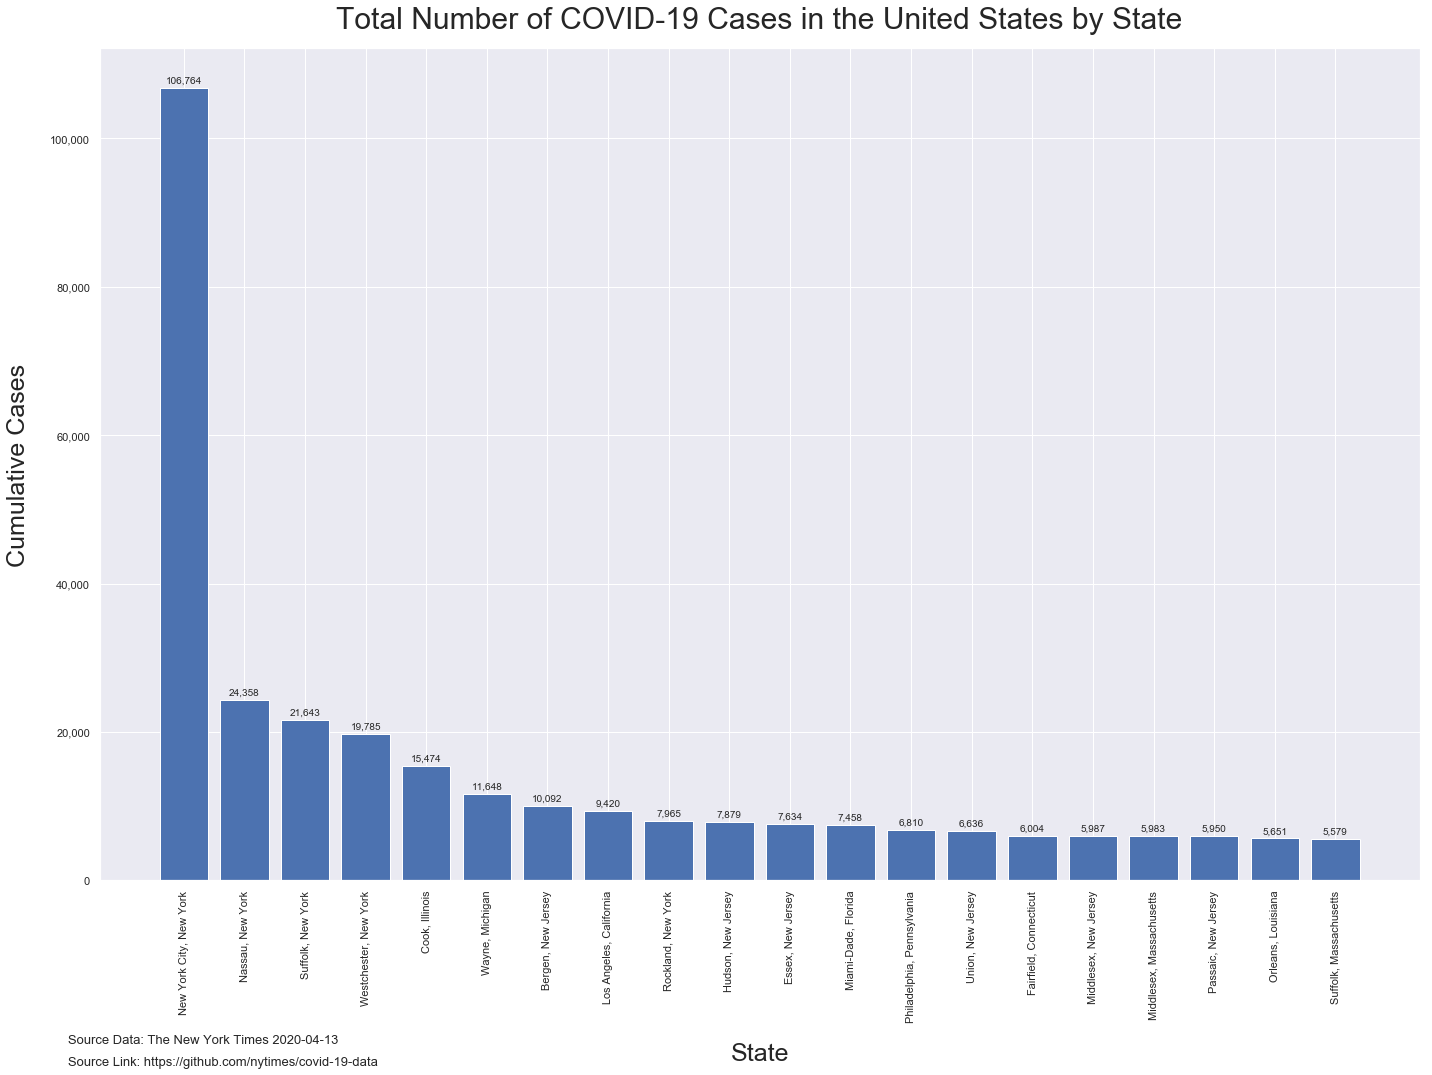

In [137]:
bar = bar.sort_values(by = 'cases', 
                    ascending=False)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label = ax.bar(bar.index, bar.cases)
plt.xlabel("State", labelpad=14, fontsize=25)
plt.xticks(rotation=90)
plt.ylabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(label)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by State", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-bar')

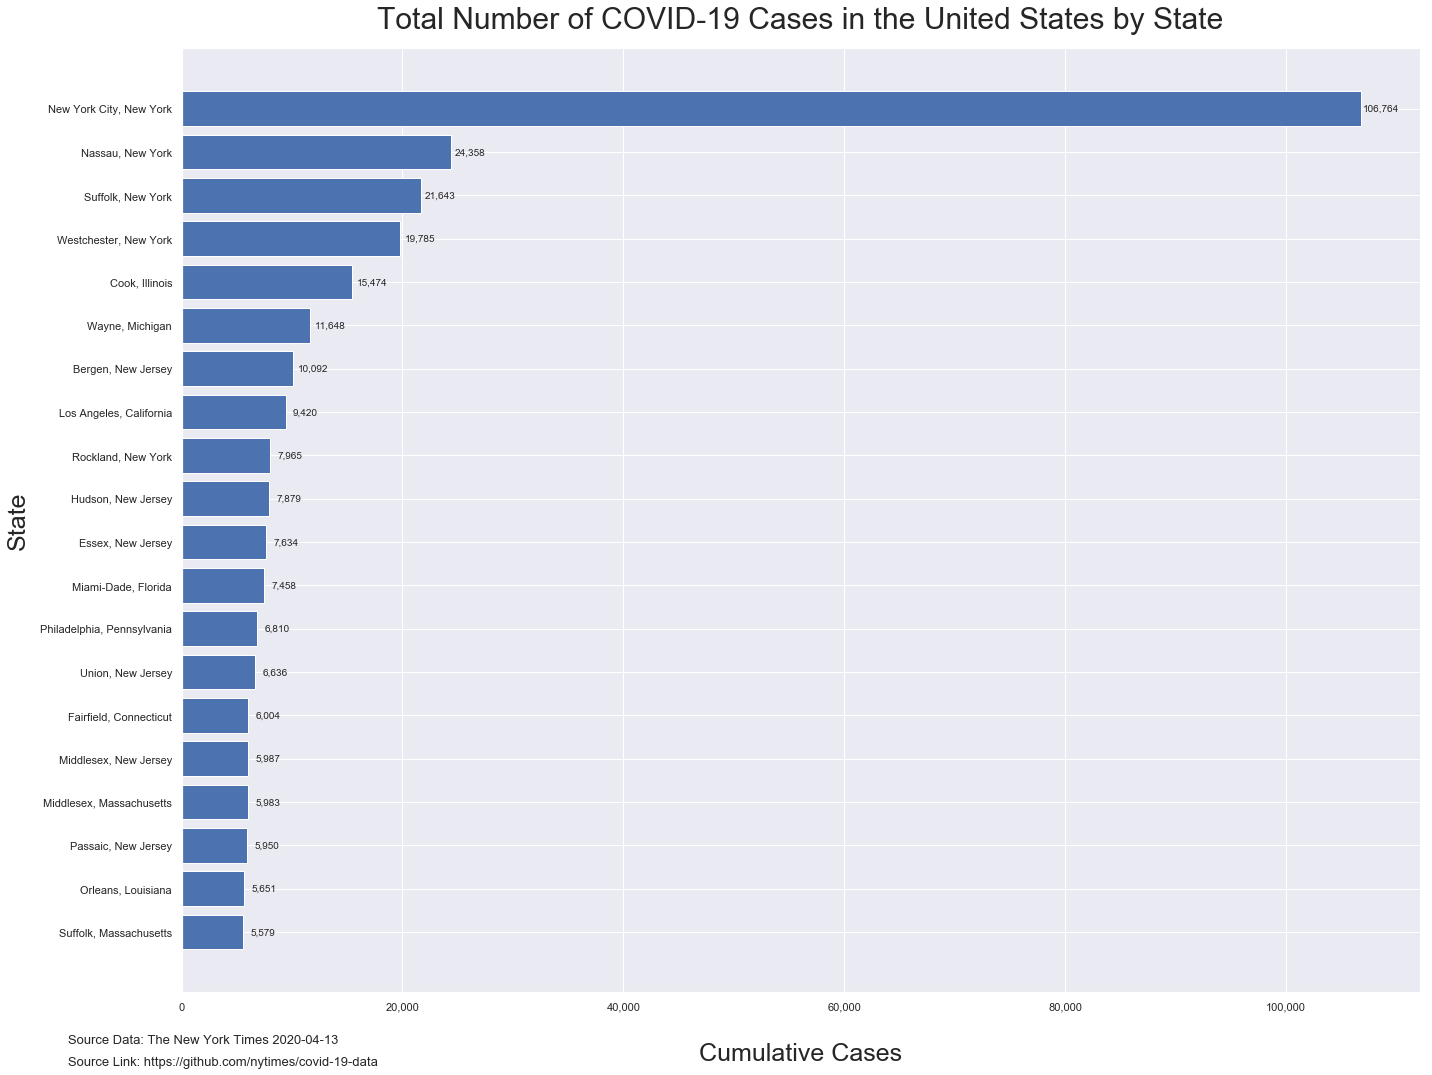

In [138]:
bar = bar.sort_values(by = 'cases', 
                    ascending=True)

bar.set_index('county_name', drop=False, inplace=True)

plt.subplots(figsize=(20,15))
ax = plt.subplot()

label_1 = ax.barh(bar.index, bar.cases)
plt.xlabel("Cumulative Cases", labelpad=14, fontsize=25)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel("State", labelpad=14, fontsize=25)
ax.xaxis.labelpad = 30
ax.yaxis.labelpad = 10

def autolabel_1(rects):
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y() + rect.get_height() / 2
        ax.annotate('{:,}'.format(width), 
                    xy=(width, yloc), 
                    xytext=(20, 0),
                    textcoords="offset points",
                    ha='center', va='center')
                
autolabel_1(label_1)

txt = ('Source Data: The New York Times ' + current_date)
txt2 = ('Source Link: https://github.com/nytimes/covid-19-data')
plt.figtext(0.05, 0.03, txt, wrap=True, horizontalalignment='left', fontsize=13)
plt.figtext(0.05, 0.01, txt2, wrap=True, horizontalalignment='left', fontsize=13)

plt.title("Total Number of COVID-19 Cases in the United States by State", pad=20, fontsize=30)
plt.tight_layout()
plt.savefig('figures/counties-barh')

In [136]:
# covid_19_counties_data.to_csv('data/us-states-raw-data.csv', index=False)
# g.to_csv('data/us-states-grouped-day.csv')
# bar.to_csv('data/us-states-grouped-states.csv')